### Chess.com Data Fetching Functions

This notebook contains functions to interact with the Chess.com API to fetch player and game data. Below is a summary of the functions provided:

### `fetch_player_data(username)`
- **Description**: Retrieves basic profile information for a given Chess.com player.
- **Arguments**:
  - `username` (str): The username of the player.
- **Returns**:
  - A dictionary with the player's data if successful.
  - `None` if the request fails.

### `fetch_monthly_games(username, year, month)`
- **Description**: Fetches all games played by a Chess.com player in a specific month and year.
- **Arguments**:
  - `username` (str): The username of the player.
  - `year` (int): The year of the games to fetch.
  - `month` (int): The month of the games to fetch.
- **Returns**:
  - A list of game dictionaries if successful.
  - `None` if the request fails.

### `fetch_all_games(username)`
- **Description**: Fetches all games ever played by a Chess.com player, starting from their account creation date.
- **Arguments**:
  - `username` (str): The username of the player.
- **Returns**:
  - A list of all game dictionaries for the player.
  - An empty list if the player's join date cannot be determined.

### `fetch_all_games_for_current_year(username, game_filter=None)`
- **Description**: Fetches all games played by a Chess.com player in the current year.
- **Arguments**:
  - `username` (str): The username of the player.
  - `game_filter` (function, optional): A function to filter games. Takes a game dictionary as input and returns `True` if the game should be included.
- **Returns**:
  - A list of game dictionaries for the current year.

In [1]:
import os
output_dir = 'static/images/'
os.makedirs(output_dir, exist_ok=True)

In [2]:
import re
import requests

def fetch_player_data(username):
    url = f"https://api.chess.com/pub/player/{username}"
    headers = {
        "User-Agent": "MyChessApp/1.0 (https://example.com)"  # ensure my request is legit 
    }
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print(f"Error: Received status code {response.status_code}")
        print(f"Response content: {response.text}")
        return None
    
    try:
        return response.json()
    except requests.exceptions.JSONDecodeError:
        print(f"Failed to parse JSON. Status code: {response.status_code}, Content: {response.text}")
        return None

#my_data = fetch_player_data("emazing19")
#print(my_data.keys())

#i only want my avatar
#what do i want? 1. their country so I can strip it, if titled, is_streamer
## Future Note: I want to extract your pfp and be able to host a wesbite showing your pfp

In [3]:
def fetch_monthly_games(username, year, month):
    url = f"https://api.chess.com/pub/player/{username}/games/{year}/{month:02}"
    headers = {
        "User-Agent": "MyChessApp/1.0 (https://example.com)"
    }
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print(f"Error: Received status code {response.status_code}")
        print(f"Response content: {response.text}")
        return None
    
    try:
        data = response.json()
        return data["games"]
    except requests.exceptions.JSONDecodeError:
        print(f"Failed to parse JSON. Status code: {response.status_code}, Content: {response.text}")
        return None

In [4]:
def fetch_all_games(username):
    player_data = fetch_player_data(username)
    if not player_data or "joined" not in player_data:
        print("Could not determine player's join date.")
        return []

    join_date = datetime.fromtimestamp(player_data["joined"])
    current_date = datetime.now()

    all_games = []
    year, month = join_date.year, join_date.month

    while (year, month) <= (current_date.year, current_date.month):
        games = fetch_monthly_games(username, year, month)
        all_games.extend(games)

        # Increment month
        if month == 12:
            year += 1
            month = 1
        else:
            month += 1

    return all_games

def fetch_all_games_for_current_year(username, game_filter=None):
    player_data = fetch_player_data(username)
    if not player_data or "joined" not in player_data:
        print("Could not determine player's join date.")
        return []
        
    current_date = datetime.now()
    all_games = []
    
    year = current_date.year
    month = 1

    while month <= current_date.month:
        games = fetch_monthly_games(username, year, month)
        if games is None:
            print(f"No games found for {username} in {year}-{month:02d}.")
            games = []  
        if game_filter:
            games = [game for game in games if game_filter(game)]
        all_games.extend(games)
        month += 1

    return all_games

def fetch_all_games_for_last_year(username, game_filter=None):
    player_data = fetch_player_data(username)
    if not player_data or "joined" not in player_data:
        print("Could not determine player's join date.")
        return []

    current_date = datetime.now()
    last_year = current_date.year - 1
    all_games = []
    year = last_year
    month = 1

    while month <= 12:
        games = fetch_monthly_games(username, year, month)
        if games is None:
            print(f"No games found for {username} in {year}-{month:02d}.")
            games = []
        if game_filter:
            games = [game for game in games if game_filter(game)]
        all_games.extend(games)

        # Increment month
        month += 1

    return all_games

### This function evaluates the positions of a chess game after every move using a chess engine, such as Stockfish. It provides insights into the game by assigning centipawn scores or detecting checkmate situations.


 **Description**: Evaluates the positions of a chess game move by move and returns a list of evaluations (centipawns or mate-in scores).


In [5]:
import chess
import chess.engine

def evaluate_positions(game_moves, engine_path, depth=5, time_limit=0.1):
    """
    Evaluates the positions of a chess game after every move using a chess engine.
    
    Args:
        game_moves (list): A list of moves for a single chess game in standard algebraic notation.
        engine_path (str): Path to the chess engine executable (e.g., '/path/to/stockfish').
        depth (int): Depth of evaluation for the chess engine.
        time_limit (float): Time limit for each move evaluation in seconds (optional, default 2.0 seconds).
    
    Returns:
        list: A list of evaluations after each move (in centipawns).
    """
    board = chess.Board()
    
    with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
        evaluations = []
        
        for move in game_moves:
            try:
                board.push_san(move)
            except ValueError as e:
                print(f"Invalid move {move}: {e}")
                break
            
            info = engine.analyse(board, chess.engine.Limit(time=time_limit))  # Set a time limit for evaluation
            
            # Get the PovScore (from the point of view of the current side to move)
            pov_score = info["score"]
            
            # Access the relative score from the PovScore object
            relative_score = pov_score.relative
            
            # Check if the relative score indicates a checkmate situation
            if relative_score.is_mate():
                eval_cp = f"M in {relative_score.mate()}"
            else:
                # For non-mate situations, use the centipawn evaluation
                eval_cp = relative_score.score(mate_score=10000)  # Centipawn score or checkmate
            
            evaluations.append(eval_cp)
    
    return evaluations


In [6]:
import re
import pandas as pd
from datetime import datetime

import re

def extract_moves_from_pgn(pgn):
    """
    Extracts only chess moves from a PGN string, ignoring move numbers, annotations, and timestamps.
    Ensures that only valid moves containing letters (indicating pieces or files) are included.
    
    Args:
        pgn (str): The PGN string containing metadata and moves.
    
    Returns:
        list: A list of chess moves in sequence, including any pawn promotions (e.g., '=Q', '=N').
    """
    # Remove PGN metadata (lines that start with '[')
    pgn_clean = re.sub(r'\[.*?\]\n', '', pgn)

    # Split the PGN into individual words (moves, annotations, timestamps)
    pgn_clean = pgn_clean.split()
    moves = []

    for word in pgn_clean:
        # Skip anything that looks like a move number (e.g., '1.', '2.', etc.)
        if word.isdigit() or '.' in word:
            continue
        
        # Skip annotations (like '{[%clk 0:02:54.6]}')
        if word.startswith('{'):
            continue
    
        if word in ['O-O', 'O-O-O']:
            moves.append(word)
        # Handle pawn promotions (e.g., d8=Q, e7=R)
        elif '=' in word:
            moves.append(word)
        # Handle regular moves (e.g., Nc6, exd5), ensure it contains at least one letter
        elif any(c.isalpha() for c in word):
            moves.append(word)

    return moves


def extract_pgn_metadata(pgn):
    """
    Extract metadata from a PGN string.
    
    Args:
        pgn (str): The PGN string containing metadata and moves.
    
    Returns:
        dict: A dictionary containing the metadata fields and their values.
    """
    metadata = {}
    metadata_lines = re.findall(r'\[(\w+)\s+"(.*?)"\]', pgn)
    for key, value in metadata_lines:
        metadata[key] = value
    return metadata

def calculate_time_difference(start_time, end_time):
    """
    Calculate the time difference between two times in HH:MM:SS format.
    
    Args:
        start_time (str): Start time in HH:MM:SS format.
        end_time (str): End time in HH:MM:SS format.
    
    Returns:
        int: Time difference in seconds, or 0 if there's an error.
    """
    try:
        fmt = "%H:%M:%S"
        start = datetime.strptime(start_time, fmt)
        end = datetime.strptime(end_time, fmt)
        delta = (end - start).seconds
        return delta
    except Exception as e:
        print(f"Error calculating time difference: {e}")
        return 0  # Return 0 seconds if there's an error

'''def extract_moves_and_timestamps(game_data):
    # Regular expression to match move numbers (multi-digit supported) and timestamps
    matches = re.findall(r'(\d+)\. \S+ \{\[%clk ([0-9:]+(?:\.[0-9]+)?)\]\}', game_data)
    # Return the last two pairs (move number, timestamp), if they exist
    return matches[:] if len(matches) >= 2 else matches'''
def extract_moves_and_timestamps(game_data):
    matches = re.findall(r'(\d+)\. \S+ \{\[%clk ([0-9:]+(?:\.[0-9]+)?)\]\}|(\d+)\.\.\. \S+ \{\[%clk ([0-9:]+(?:\.[0-9]+)?)\]\}', game_data)
    
    # Extract only move numbers and timestamps
    white_moves = [(move[0], move[1]) for move in matches if move[0] != '']
    black_moves = [(move[2], move[3]) for move in matches if move[2] != '']
    return white_moves, black_moves

def format_single_time_control(time_control):
    """
    Formats the time control into a user-friendly string.
    Handles cases with very short time controls like 1 second games.
    
    Args:
        time_control (str): Time control string in the format "base+increment" (e.g., "60+1").
    
    Returns:
        str: Formatted time control string.
    """
    if '/' in time_control:
        # Handle Chess.com's daily format like "1/259200"
        parts = time_control.split('/')
        if len(parts) == 2 and parts[0].isdigit() and parts[1].isdigit():
            days = int(parts[0]) / (int(parts[1]) / 86400)  # Convert fraction to days
            return f"{days:.1f} day(s) per move"
        else:
            return f"Unrecognized format: {time_control}"
    if '+' in time_control:
        base, increment = map(int, time_control.split('+'))
    else:
        #print(f"Testing Time_Control Value {time_control}")
        base, increment = int(time_control), 0

    # Convert base time to minutes and seconds
    minutes = base // 60
    seconds = base % 60
    
    if minutes > 0:
        base_str = f"{minutes}m {seconds}s" if seconds > 0 else f"{minutes}m"
    else:
        base_str = f"{seconds}s"
    
    increment_str = f"{increment}s" if increment > 0 else "0s"

    return f"{base_str} + {increment_str}"
    

def convert_to_est(time_str):
    # Convert string time to a datetime object (using the date 1900-01-01 as it's irrelevant here)
    time = pd.to_datetime(time_str, format='%H:%M:%S')
    
    # Subtract 5 hours to convert from UTC to EST
    est_time = time - pd.Timedelta(hours=5)
    
    # Return the time in 'HH:MM:SS' format
    return est_time.strftime('%H:%M:%S')
    
def fetch_and_process_game_data(username, engine_path="/opt/homebrew/bin/stockfish"):
    all_games = fetch_all_games_for_last_year(username) ## change to current year if necessary
    game_data = []

    for game in all_games:

        if 'pgn' not in game:
            continue  # Skip this game if 'pgn' is missing (these are bughouse games or weird ass games)
            
        pgn = game['pgn']

        time_control = format_single_time_control(game['time_control'])
        
        metadata = extract_pgn_metadata(pgn)

        date = metadata.get('Date', None)
        
        start_time = metadata.get('StartTime', None)
        end_time = metadata.get('EndTime', None)

        start_time_est = convert_to_est(start_time)
        end_time_est = convert_to_est(end_time)
            
        link = metadata.get('Link', None)
        eco = metadata.get('ECOUrl', None)
        time_spent = calculate_time_difference(start_time, end_time)
        moves = extract_moves_from_pgn(pgn) 
        w_metamoves, b_metamoves = extract_moves_and_timestamps(pgn)
        
        data = {
            'url': game['url'],
            'pgn': pgn,
            'moves': moves,
            'date': date,
            'start_time_est': start_time_est,
            'end_time_est': end_time_est,
            'time_spent': time_spent,
            'link': link,
            'time_control': time_control,
            'time_class': game['time_class'],
            'game_type': game['rules'],
            'rated': game['rated'],
            'tcn': game['tcn'],
            'uuid': game['uuid'],
            'initial_setup': game['initial_setup'],
            'fen': game['fen'], #this is the position
            'rules': game['rules'],
            'white_username': game['white']['username'],
            'white_rating': game['white']['rating'],
            'white_result': game['white']['result'],
            'white_metamoves': w_metamoves,
            'black_username': game['black']['username'],
            'black_rating': game['black']['rating'],
            'black_result': game['black']['result'],
            'black_metamoves': b_metamoves,
            'eco': eco
        }
        game_data.append(data)

    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(game_data)
    
    return df


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/edwardlai/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/edwardlai/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/edwardlai/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/edwardlai/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/edwardlai/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/edwardlai/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/edwardlai/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/edwardlai/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/edwardlai/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/edwardlai/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/edwardlai/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/edwardlai/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "

AttributeError: _ARRAY_API not found

In [7]:

'''
import pandas as pd
import numpy as np
import chess
import chess.engine
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Function to get Stockfish evaluation for a given position
def get_position_evaluation(board, engine_path='/opt/homebrew/bin/stockfish'):
    with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
        info = engine.analyse(board, chess.engine.Limit(time=0.1))  # 0.1s time per position
        score = info['score'].relative.score(mate_score=10000)
        return score if score is not None else 0

# Convert algebraic notation to UCI format
def move_to_uci(move, board):
    """
    Convert a move in algebraic notation to UCI format.
    Assumes the move is valid for the current board state.
    
    Args:
        move (str): The move in algebraic notation (e.g., 'd4', 'Nc6').
        board (chess.Board): The current board state.
    
    Returns:
        str: The move in UCI format (e.g., 'e2e4', 'Ng1f3').
    """
    try:
        # Try to parse the move using SAN (Standard Algebraic Notation)
        chess_move = board.push_san(move)  # This pushes the move to the board
        uci_move = chess_move.uci()  # Convert the chess.Move object to UCI format
        return uci_move
    except ValueError:
        raise ValueError(f"Invalid move: {move}")

# Function to process the moves and generate features
def process_game(pgn, engine_path='/opt/homebrew/bin/stockfish'):
    moves = extract_moves_from_pgn(pgn)  # Ensure this function works as expected
    board = chess.Board()  # Start from the initial position
    print(board.legal_moves)
    
    features = []
    

    for move in moves:
        try:
            print(f"Current board:\n{board}")  # Print the current board state
            print(f"Trying move: {move}")
            
            
            # Ensure the move is legal before applying it
            if move in board.legal_moves:
                print(f"Move {move} is legal.")
                
                # Convert the move to UCI format and apply it
                uci_move = move_to_uci(move, board)
                print(f"UCI move: {uci_move}")  # Debugging: Check the UCI move output
                
                # Get the evaluation of the position after the move
                evaluation = get_position_evaluation(board, engine_path)
                features.append(evaluation)
            else:
                print(f"Move {move} is illegal in the current position.")
        
        except ValueError as e:
            print(f"Error: ValueError - {e}")
        except Exception as e:
            print(f"Unexpected error: {e}")
            print(f"Move: {move}")  # This helps to know which move caused the issue.
            print(f"Type of move: {type(move)}")  # Check the type of 'move'
        
    return features


# Assuming you have a DataFrame `df` containing your games
# Extract features and labels (e.g., win or loss)
X = []
y = []

for idx, row in df.iterrows():
    pgn = row['pgn']
    outcome = row['white_result']  # Assume 'outcome' is 1 for win, 0 for loss (or other encoding)
    if outcome == 'win':
        outcome = 1
    else:
        outcome = 0

    # Extract features from the game
    features = process_game(pgn)
    X.append(features)
    y.append(outcome)

# Convert lists into numpy arrays for machine learning
X = np.array(X)
y = np.array(y)

# Step 4: Train the model
# Flatten the features to make them compatible for training
X_flattened = X.reshape(X.shape[0], -1)  # Flattening the moves (each move's evaluation)
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy * 100:.2f}%')
'''

'\nimport pandas as pd\nimport numpy as np\nimport chess\nimport chess.engine\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\n\n# Function to get Stockfish evaluation for a given position\ndef get_position_evaluation(board, engine_path=\'/opt/homebrew/bin/stockfish\'):\n    with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:\n        info = engine.analyse(board, chess.engine.Limit(time=0.1))  # 0.1s time per position\n        score = info[\'score\'].relative.score(mate_score=10000)\n        return score if score is not None else 0\n\n# Convert algebraic notation to UCI format\ndef move_to_uci(move, board):\n    """\n    Convert a move in algebraic notation to UCI format.\n    Assumes the move is valid for the current board state.\n    \n    Args:\n        move (str): The move in algebraic notation (e.g., \'d4\', \'Nc6\').\n        board (chess.Board): The current board s

### Data Processing and Preparation

In [8]:
import pandas as pd
import numpy as np

def clean_dataframe(df, username):
    """
    Cleans and processes a chess DataFrame.

    Parameters:
        df (pd.DataFrame): The original DataFrame to clean.
        username (str): The username of the player to analyze.

    Returns:
        pd.DataFrame: The cleaned and processed DataFrame.
    """
    cleaned_df = df.copy()

    # Clean and process the 'eco' column
    cleaned_df['eco'] = cleaned_df['eco'].str.split('/openings/').str[1]

    def truncate_eco(name):
        if name is None:
            return 'No Opening'
        keywords = ["Defense", "Gambit", "Opening", "Game", "Attack", "System"]
        first_position = len(name)
        keyword_found = None
        for keyword in keywords:
            pos = name.find(keyword)
            if pos != -1 and pos < first_position:  # Find the earliest occurrence
                first_position = pos
                keyword_found = keyword
        # If a keyword was found, truncate up to the end of the keyword
        return name[:first_position + len(keyword_found)] if keyword_found else name

    cleaned_df['eco'] = cleaned_df['eco'].apply(truncate_eco)

    columns_to_initialize = [
        'my_username', 'my_rating', 'my_result', 'my_color', 'my_win_or_lose', 'my_metamoves',
        'opp_username', 'opp_rating', 'opp_result', 'opp_metamoves' #do i have to initialize my_color
    ]
    for column in columns_to_initialize:
        cleaned_df[column] = None

    for index, row in cleaned_df.iterrows():
        if row['white_username'].lower() == username.lower():
            cleaned_df.at[index, 'my_username'] = row['white_username']
            cleaned_df.at[index, 'my_rating'] = row['white_rating']
            cleaned_df.at[index, 'my_result'] = row['white_result']
            cleaned_df.at[index, 'my_color'] = 'white'
            cleaned_df.at[index, 'my_metamoves'] = row['white_metamoves']
            cleaned_df.at[index, 'opp_username'] = row['black_username']
            cleaned_df.at[index, 'opp_rating'] = row['black_rating']
            cleaned_df.at[index, 'opp_result'] = row['black_result']
            cleaned_df.at[index, 'opp_metamoves'] = row['black_metamoves']
            cleaned_df.at[index, 'my_win_or_lose'] = 'win' if row['white_result'] == 'win' else 'draw' if row['white_result'] in ['draw', 'stalemate', 'repetition', 'insufficient', 'timevsinsufficient'] else 'lose'

        elif row['black_username'].lower() == username.lower():
            cleaned_df.at[index, 'my_username'] = row['black_username']
            cleaned_df.at[index, 'my_rating'] = row['black_rating']
            cleaned_df.at[index, 'my_result'] = row['black_result']
            cleaned_df.at[index, 'my_color'] = 'black'
            cleaned_df.at[index, 'my_metamoves'] = row['black_metamoves']
            cleaned_df.at[index, 'opp_username'] = row['white_username']
            cleaned_df.at[index, 'opp_rating'] = row['white_rating']
            cleaned_df.at[index, 'opp_result'] = row['white_result']
            cleaned_df.at[index, 'opp_metamoves'] = row['white_metamoves']
            cleaned_df.at[index, 'my_win_or_lose'] = 'win' if row['black_result'] == 'win' else 'draw' if row['black_result'] in ['draw', 'stalemate', 'repetition', 'insufficient', 'timevsinsufficient'] else 'lose'
        else:
            print(f"BIG FUCKING Error: username '{username}' not found in either white or black columns at index {index}")
            print(f"White Username: {row['white_username']}, Black Username: {row['black_username']}, Game Link: {row['link']}")

    def time_string_to_seconds_with_fraction(time_str):
        # Split the string into hours, minutes, and seconds
        h, m, s = map(float, time_str.split(':'))
        # Calculate total seconds, including fractional seconds
        return h * 3600 + m * 60 + s

    def convert_time_class_to_seconds(time_class):
        """
        Converts a time control string into total seconds.
        Handles formats like '5+5' (base + increment), '5m + 0s', and Chess.com's daily formats like '1/259200'.
        
        Args:
            time_class (str): The time control string.
        
        Returns:
            float or str: Total seconds for the base time or "Weird" if unrecognized.
        """
        if 'm' in time_class and '+' in time_class:
            # Handle formats like '5m + 0s'
            try:
                base_part, increment_part = time_class.split('+')
                base_minutes = int(base_part.replace('m', '').strip())
                increment_seconds = int(increment_part.replace('s', '').strip())
                return base_minutes * 60 + increment_seconds
            except ValueError:
                return "Weird"
        
        if '/' in time_class:
            # Handle Chess.com's daily format
            parts = time_class.split('/')
            if len(parts) == 2 and parts[0].isdigit() and parts[1].isdigit():
                base_days = int(parts[0]) / (int(parts[1]) / 86400)  # Convert fraction to days in seconds
                return base_days * 86400
            else:
                return "Weird"
        
        if '+' in time_class:
            # Handle formats like '5+5'
            try:
                base_minutes = int(time_class.split('+')[0].strip())
                return base_minutes * 60
            except ValueError:
                return "Weird"
        
        # Default case for unrecognized formats
        return "Weird"

    # Calculate time-related columns
    cleaned_df['my_time_left'] = np.where(
        cleaned_df['my_result'].isin(['timeout', 'timevsinsufficient']), 0, 
        cleaned_df['my_metamoves'].apply(lambda x: time_string_to_seconds_with_fraction(x[-1][1]) if x and len(x[-1]) > 1 else 0) #account for empty 
    )

    cleaned_df['opp_time_left'] = np.where(
        cleaned_df['opp_result'].isin(['timeout', 'timevsinsufficient']), 0, 
        cleaned_df['opp_metamoves'].apply(lambda x: time_string_to_seconds_with_fraction(x[-1][1]) if x and len(x[-1]) > 1 else 0) #account for empty 
    )
    
    cleaned_df['my_num_moves'] = cleaned_df['my_metamoves'].apply(lambda x: len(x) if x else 0)


        # Add a safe calculation for ratios, only if time_control is valid
    def safe_time_left_ratio(row, col_name):
        time_control_seconds = convert_time_class_to_seconds(row['time_control'])
        if time_control_seconds == "Weird" or time_control_seconds == 0:
            return np.nan  # Return NaN for invalid or unrecognized time controls
        return row[col_name] / time_control_seconds
    
    cleaned_df['my_time_left_ratio'] = cleaned_df.apply(
        lambda row: safe_time_left_ratio(row, 'my_time_left'),
        axis=1
    )
    
    cleaned_df['opp_time_left_ratio'] = cleaned_df.apply(
        lambda row: safe_time_left_ratio(row, 'opp_time_left'),
        axis=1
    )


    # Split moves based on player color
    def split_moves(row):
        moves = row['moves']
        if row['my_color'] == 'white':
            my_moves = moves[::2]  # Take odd positions (0-indexed: 0, 2, 4, ...)
            opp_moves = moves[1::2]  # Take even positions (1-indexed: 1, 3, 5, ...)
        else:
            my_moves = moves[1::2]  # Take even positions (1-indexed: 1, 3, 5, ...)
            opp_moves = moves[::2]  # Take odd positions (0-indexed: 0, 2, 4, ...)
        return my_moves, opp_moves

    # Track castling
    def track_castling(my_moves):
        if 'O-O-O' in my_moves:
            return 'queenside'
        elif 'O-O' in my_moves:
            return 'kingside'
        else:
            return 'none'

    # Apply the functions to the dataframe
    cleaned_df[['my_moves', 'opp_moves']] = cleaned_df.apply(
        lambda row: pd.Series(split_moves(row)), axis=1
    )
    cleaned_df['my_castling'] = cleaned_df['my_moves'].apply(track_castling)
    cleaned_df['opp_castling'] = cleaned_df['opp_moves'].apply(track_castling)

    def count_promotions(my_moves):
        """Counts the number of promotions in the given list of moves."""
        return sum('=' in move for move in my_moves)

    def count_en_passant(my_moves):
        """Counts the number of en passant occurrences in the given list of moves."""
        return sum('e.p.' in move for move in my_moves)

    cleaned_df['en_passant_count'] = cleaned_df['my_moves'].apply(count_en_passant)
    cleaned_df['promotion_count'] = cleaned_df['my_moves'].apply(count_promotions)

    def get_country(username):
        # Would be cool if I found out all the opponents that you played that were streamers, titled, or country
        # cleaned_df['country'] = cleaned_df['opp_username'].apply(get_country) takes 162 seconds lol way too long

        """Gets the country of the opponent"""
        opp_data = fetch_player_data(username)
        #print(opp_data['country'])
        return opp_data['country']
    
    return cleaned_df

## Statistic Functions

In [9]:
def total_statistics(cleaned_df):
    # Count the occurrences of each type of castling
    castling_counts = cleaned_df['my_castling'].value_counts()

    # Store the counts in variables
    kingside_castles = castling_counts.get('kingside', 0)
    queenside_castles = castling_counts.get('queenside', 0)
    no_castles = castling_counts.get('none', 0)

    # Count the result occurrences
    result_counts = cleaned_df['my_result'].value_counts()
    total_games = len(cleaned_df)
    total_win = result_counts.get('win', 0)
    total_checkmated = result_counts.get('checkmated', 0)
    total_timeout = result_counts.get('timeout', 0)
    total_timevsinsufficient = result_counts.get('timevsinsufficient', 0)
    total_resigned = result_counts.get('resigned', 0)
    total_stalemate = result_counts.get('stalemate', 0)
    total_repetition = result_counts.get('repetition', 0)
    total_abandoned = result_counts.get('abandoned', 0)
    total_insufficient = result_counts.get('insufficient', 0)

    total_draw = total_stalemate + total_repetition + total_timevsinsufficient + total_insufficient
    total_loss = total_checkmated + total_timeout + total_resigned + total_abandoned
    total_moves = cleaned_df['my_num_moves'].sum()
    total_time_spent = cleaned_df['time_spent'].sum()
    #total_thinking_time_spent = cleaned_df['']

    # Sum the total occurrences of en passant and promotions
    total_en_passant = cleaned_df['en_passant_count'].sum()
    total_promotions = cleaned_df['promotion_count'].sum()

    # Prepare the statistics dictionary with total counts only
    statistics = {
        'kingside_castles': kingside_castles,
        'queenside_castles': queenside_castles,
        'no_castles': no_castles,
        'total_time_spent': total_time_spent,
        'total_moves': total_moves,
        'total_win': total_win,
        'total_draw': total_draw,
        'total_loss': total_loss,
        'total_checkmated': total_checkmated,
        'total_timeout': total_timeout,
        'total_timevsinsufficient': total_timevsinsufficient,
        'total_resigned': total_resigned,
        'total_stalemate': total_stalemate,
        'total_repetition': total_repetition,
        'total_abandoned': total_abandoned,
        'total_insufficient': total_insufficient,
        'total_en_passant': total_en_passant,
        'total_promotions': total_promotions,
        'total_games': total_games
    }

    return statistics

In [10]:


import pandas as pd
from datetime import datetime
from itertools import groupby

# Function to calculate win rates by opening
def calculate_win_rates(df):
    win_rates = (
        df.groupby('eco')['my_win_or_lose']
        .apply(lambda x: (x == 'win').sum() / len(x))
        .reset_index(name='win_rate')
    )
    return win_rates

# Function to count games played by opening
def count_games_played(df):
    games_played = df['eco'].value_counts().reset_index()
    games_played.columns = ['eco', 'Games_Played']
    return games_played

# Function to merge win rates and games played
def merge_opening_stats(win_rates, games_played):
    openings_stats = win_rates.merge(games_played, on='eco')
    return openings_stats

# Function to calculate win/loss/draw percentages
def calculate_win_loss_draw_percentages(df):
    total_games = len(df)
    win_percentage = (df['my_win_or_lose'] == 'win').mean() * 100
    loss_percentage = (df['my_win_or_lose'] == 'lose').mean() * 100
    draw_percentage = (df['my_win_or_lose'] == 'draw').mean() * 100
    return win_percentage, loss_percentage, draw_percentage

# Function to calculate Elo progression
def calculate_elo_progression(df):
    df['date'] = pd.to_datetime(df['date'])
    elo_progression = df.groupby('date')['my_rating'].mean()
    return elo_progression

# Function to calculate the longest streak
def longest_streak(results, target):
    streak = max((len(list(g)) for k, g in groupby(results) if k == target), default=0)
    return streak

# Function to find the quickest checkmate
def find_quickest_checkmate(df):
    df['num_moves'] = df['moves'].apply(len)
    quickest_win = df.loc[(df['my_win_or_lose'] == 'win') & (df['num_moves'] == df['num_moves'].min())]
    return quickest_win

# Function to find best game by rating difference
def find_best_game_by_rating(df):
    df['rating_diff'] = df['my_rating'] - df['opp_rating']
    best_game = df.loc[(df['my_win_or_lose'] == 'win') & (df['rating_diff'] == df['rating_diff'].max())]
    return best_game

# Function to calculate total time spent
def calculate_total_time_spent(df):
    total_time_spent = df['time_spent'].sum() / 3600  # Convert seconds to hours
    return total_time_spent

# Function to calculate most played opponent
def most_played_opponent(df):
    most_played_opponent = df['opp_username'].value_counts().reset_index()
    most_played_opponent.columns = ['Opponent', 'Games_Played']
    return most_played_opponent

# Function to collect statistics into a dictionary
def collect_statistics(df):
    stats = {}

    # Opening stats
    win_rates = calculate_win_rates(df)
    games_played = count_games_played(df)
    openings_stats = merge_opening_stats(win_rates, games_played)
    most_played_openings = openings_stats.sort_values(by='Games_Played', ascending=False)
    stats['most_played_openings'] = most_played_openings.head()

    # Win/Loss/Draw percentages
    win_percentage, loss_percentage, draw_percentage = calculate_win_loss_draw_percentages(df)
    stats['win_loss_draw_percentages'] = {
        'win_percentage': win_percentage,
        'loss_percentage': loss_percentage,
        'draw_percentage': draw_percentage
    }

    # Streaks
    winning_streak = longest_streak(df['my_win_or_lose'], 'win')
    losing_streak = longest_streak(df['my_win_or_lose'], 'lose')
    stats['streaks'] = {
        'winning_streak': winning_streak,
        'losing_streak': losing_streak
    }

    # Quickest checkmate
    quickest_win = find_quickest_checkmate(df)
    stats['quickest_checkmate'] = quickest_win[['date', 'moves', 'my_rating', 'opp_rating', 'my_num_moves', 'link']]

    # Total time spent
    total_time_spent = calculate_total_time_spent(df)
    stats['total_time_spent'] = total_time_spent

    # Best game by rating difference
    best_game = find_best_game_by_rating(df)
    stats['best_game_by_rating'] = best_game[['date', 'moves', 'my_rating', 'opp_rating', 'my_num_moves', 'link']]

    # Most played opponent
    most_played_opponent_df = most_played_opponent(df)
    stats['most_played_opponent'] = most_played_opponent_df.head()

    return stats




In [11]:
def get_flag_statistics(cleaned_df):
    # Filter for wins where 'my_win_or_lose' is 'win' (games where you flagged the opponent)
    my_filtered_wins = cleaned_df[
        (cleaned_df['my_win_or_lose'] == 'win') &
        (cleaned_df['my_time_left'] >= 0.1) &
        (cleaned_df['my_time_left'] <= 5)
    ]

    top_10_flagged_games = my_filtered_wins.sort_values(by='opp_time_left').head(10)

    opp_filtered_wins = cleaned_df[
        (cleaned_df['my_win_or_lose'] == 'win') &
        (cleaned_df['opp_time_left'] >= 0.1) &
        (cleaned_df['opp_time_left'] <= 5)
    ]

    # Sort by 'my_time_left' (ascending) to get the games where you were flagged the most
    top_10_get_flagged_games = opp_filtered_wins.sort_values(by='my_time_left').head(10)

    # Group by relevant columns and get counts for both filtered dataframes
    my_flag_counts = my_filtered_wins.groupby(['my_time_left', 'my_win_or_lose', 'link']).size().sort_index()
    opp_flag_counts = opp_filtered_wins.groupby(['my_time_left', 'my_win_or_lose', 'link']).size().sort_index()

    # Store statistics in a dictionary
    flag_statistics = {
        "my_total_flag_wins": len(my_filtered_wins),
        "my_total_flag_losses": len(opp_filtered_wins),
        "top_10_flagged_games": top_10_flagged_games[['link', 'opp_time_left', 'my_time_left', 'my_win_or_lose', 'my_color']].to_dict(orient='records'),
        "top_10_get_flagged_games": top_10_get_flagged_games[['link', 'opp_time_left', 'my_time_left', 'my_win_or_lose', 'my_color']].to_dict(orient='records'),
        #"my_flag_counts": my_flag_counts.to_dict(),
        #"opp_flag_counts": opp_flag_counts.to_dict()
    }

    return flag_statistics

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_game_statistics(cleaned_df, output_dir):
    """
    This function processes the cleaned dataframe and generates three plots:
    - Frequency of games played over months
    - Frequency of games played by weekday
    - Frequency of games played by hour of day
    """
    # Ensure that 'timestamp' column is a datetime object
    cleaned_df['timestamp'] = pd.to_datetime(cleaned_df['date'])

    # Extract the month and year from the 'timestamp' column
    cleaned_df['month'] = cleaned_df['timestamp'].dt.to_period('M')

    # Extract the weekday (0 = Monday, 6 = Sunday)
    cleaned_df['weekday'] = cleaned_df['timestamp'].dt.day_name()

    # Extract the hour of the day from 'start_time_est'
    cleaned_df['hour'] = cleaned_df['start_time_est'].str.split(':').str[0].astype(int)

    # 1. Count the frequency of games played each month
    monthly_counts = cleaned_df['month'].value_counts().sort_index()

    # 2. Count the frequency of games played by weekday
    weekday_counts = cleaned_df['weekday'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

    # 3. Count the frequency of games played by hour
    hourly_counts = cleaned_df['hour'].value_counts().sort_index()

    # Plotting the frequency of games over months (Using plt.bar instead of sns.barplot)
    plt.figure(figsize=(10, 6))
    plt.bar(monthly_counts.index.astype(str), monthly_counts.values, color='skyblue')  # Choose a color
    plt.title('Frequency of Games Played Over Months')
    plt.xlabel('Month')
    plt.ylabel('Frequency of Games')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.savefig(f"{output_dir}image_1.png")
    #plt.show()

    # Plotting the frequency of games by weekday (Using plt.bar instead of sns.barplot)
    plt.figure(figsize=(10, 6))
    plt.bar(weekday_counts.index, weekday_counts.values, color='lightgreen')  # Choose a color
    plt.title('Frequency of Games Played by Weekday')
    plt.xlabel('Weekday')
    plt.ylabel('Frequency of Games')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{output_dir}image_2.png")
    #plt.show()

    # Plotting the frequency of games by hour (Using plt.bar instead of sns.barplot)
    plt.figure(figsize=(10, 6))
    plt.bar(hourly_counts.index.astype(str), hourly_counts.values, color='lightcoral')  # Choose a color
    plt.title('Frequency of Games Played by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Frequency of Games')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{output_dir}image_3.png")
    #plt.show()


In [13]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_opening_statistics(cleaned_df, output_dir):

    opening_stats = cleaned_df.groupby(['eco', 'my_win_or_lose']).size().unstack(fill_value=0)

    # Calculate total games per opening
    opening_stats['total'] = opening_stats.sum(axis=1)

    # Sort by the total number of games played and keep only the top 10
    top_10_openings = opening_stats.sort_values(by='total', ascending=False).head(10)

    # Normalize the stats to get win, draw, and loss rates
    top_10_openings_normalized = top_10_openings.div(top_10_openings['total'], axis=0).drop(columns=['total'])

    # Ensure 'win', 'draw', and 'lose' columns exist
    for col in ['win', 'draw', 'lose']:
        if col not in top_10_openings_normalized.columns:
            top_10_openings_normalized[col] = 0

    # Plot the stacked bar chart
    fig, ax = plt.subplots(figsize=(12, 8))

    # Define colors for win, draw, and lose
    color_map = {'win': 'green', 'draw': 'gray', 'lose': 'red'}

    # Plot each segment
    bottom = None
    for outcome in ['win', 'draw', 'lose']:
        if bottom is None:
            bottom = top_10_openings_normalized[outcome]
            ax.bar(top_10_openings.index, top_10_openings_normalized[outcome], label=outcome.capitalize(), color=color_map[outcome])
        else:
            ax.bar(top_10_openings.index, top_10_openings_normalized[outcome], bottom=bottom, label=outcome.capitalize(), color=color_map[outcome])
            bottom += top_10_openings_normalized[outcome]

    # Add game counts as labels above the bars
    for idx, total_games in enumerate(top_10_openings['total']):
        ax.text(idx, 1.02, f'{int(total_games)} games', ha='center', fontsize=10, color='black')

    # Customize the plot
    plt.title('Win/Draw/Loss Rates for Top 10 Most Common Openings (with Game Counts)', pad=50)
    plt.xlabel('Opening')
    plt.ylabel('Rate')
    plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability
    plt.legend(title='Outcome', loc='upper right')
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(f"{output_dir}image_4.png")
    #plt.show()

In [14]:
import matplotlib.pyplot as plt

def plot_time_control_statistics(cleaned_df, output_dir):
    # Get unique time_controls
    time_controls = cleaned_df['time_control'].unique()

    # Set up the number of columns (e.g., 2 columns per row)
    n_cols = 2  # Set number of columns to 2 (you can adjust this)
    n_rows = (len(time_controls) + n_cols - 1) // n_cols  # Calculate number of rows dynamically

    # Set up the subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 8))
    axes = axes.flatten()  # Flatten the axes array to make indexing easier

    # Define custom colors: Green for win, Red for loss, Gray for draw
    color_map = {'win': 'green', 'lose': 'red', 'draw': 'gray'}

    # Loop through each time_control and plot the pie chart
    for i, time_control in enumerate(time_controls):
        # Filter the DataFrame for the current time_control
        time_control_data = cleaned_df[cleaned_df['time_control'] == time_control]

        # Count the occurrences of 'my_win_or_lose' for that time_control
        win_loss_counts = time_control_data['my_win_or_lose'].value_counts()


        # Ensure 'win', 'lose', and 'draw' are included even if missing
        for result in ['win', 'lose', 'draw']:
            if result not in win_loss_counts:
                win_loss_counts[result] = 0

        # Sort by expected order
        win_loss_counts = win_loss_counts[['win', 'lose', 'draw']]

        # Skip empty data (all counts zero)
        if win_loss_counts.sum() == 0:
            print(f"Debugging: Skipping {time_control} as all counts are zero.")
            continue

        # Define colors based on outcomes
        colors = [color_map[result] for result in win_loss_counts.index]

        # Create labels with both count and percentage
        total_games = win_loss_counts.sum()
        labels = [f'{result} - {count} games' for result, count in zip(win_loss_counts.index, win_loss_counts)]
        label_text = f'Total: {total_games} games'

        # Plot a pie chart for the current time_control
        ax = axes[i]  # Use the i-th axis in the flattened axes array
        wedges, texts, autotexts = ax.pie(
            win_loss_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors
        )

        # Set title and aspect ratio
        ax.set_title(f'{time_control} Win/Loss/Draw Distribution')
        ax.axis('equal')  # Ensures pie chart is circular

        # Add total games label below the pie chart
        ax.text(0, -1.4, label_text, ha='center', va='center', fontsize=12, color='black')

    # Hide unused subplots (for empty time_controls)
    for j in range(len(time_controls), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save and display the pie charts
    print("Debugging: Saving and displaying the pie charts.")
    #plt.savefig(f"{output_dir}image_5.png")
    #plt.show()

In [15]:
import matplotlib.pyplot as plt

def plot_time_class_statistics(cleaned_df, output_dir):
    # Get unique time_classes
    time_classes = cleaned_df['time_class'].unique()

    # Set up the number of rows and columns for the subplots
    n_cols = len(time_classes)  # Create one subplot per time_class
    n_rows = 1  # All in one row
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, 8))  # Adjust figsize as needed

    # Define new color palette
    win_color = '#66b3ff'  # Soft blue for win
    lose_color = '#ff6666'  # Soft red for loss
    draw_color = '#ffcc99'  # Soft orange for draw

    # Loop through each time_class and plot the pie chart
    for i, time_class in enumerate(time_classes):
        # Filter the DataFrame for the current time_class
        time_class_data = cleaned_df[cleaned_df['time_class'] == time_class]
        
        # Count the occurrences of 'my_win_or_lose' for that time_class (including 'draw')
        win_loss_counts = time_class_data['my_win_or_lose'].value_counts()

        # Make sure all outcomes (win, loss, draw) are represented
        outcomes = ['win', 'lose', 'draw']
        win_loss_counts = win_loss_counts.reindex(outcomes, fill_value=0)

        # Define custom colors (subtle, elegant shades)
        colors = [win_color, lose_color, draw_color]
        
        # Create labels with both count and percentage
        total_games = len(time_class_data)
        labels = [f'{result} - {count} games' for result, count in zip(win_loss_counts.index, win_loss_counts)]
        # Add total games count at the bottom of the chart
        label_text = f'Total: {total_games} games'
        
        # Plot a pie chart for the current time_class
        ax = axes[i] if n_cols > 1 else axes  # Adjust axes indexing based on the number of columns
        wedges, texts, autotexts = ax.pie(win_loss_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
        
        # Set title  
        ax.set_title(f'{time_class} Win/Loss/Draw Distribution')
        
        # Adjust the label text position for the pie chart
        ax.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
        
        # Add total games label below the pie chart
        ax.text(0, -1.4, label_text, ha='center', va='center', fontsize=12, color='black')

    # Adjust layout for better spacing between charts
    plt.tight_layout()

    # Save the pie charts as an image
    plt.savefig(f"{output_dir}image_5.png")
    #plt.show()

In [16]:
def plot_game_outcome_by_hour(cleaned_df, output_dir):
    # Filter rows for wins, losses, and draws
    wins_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'win'].copy()
    losses_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'lose'].copy()
    draws_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'draw'].copy()

    # Convert 'start_time_est' to datetime and extract the hour
    wins_data['start_time_est'] = pd.to_datetime(wins_data['start_time_est'], format='%H:%M:%S')
    losses_data['start_time_est'] = pd.to_datetime(losses_data['start_time_est'], format='%H:%M:%S')
    draws_data['start_time_est'] = pd.to_datetime(draws_data['start_time_est'], format='%H:%M:%S')

    # Extract the hour from the 'start_time_est' column
    wins_data['hour'] = wins_data['start_time_est'].dt.hour
    losses_data['hour'] = losses_data['start_time_est'].dt.hour
    draws_data['hour'] = draws_data['start_time_est'].dt.hour

    # Group by hour and count the wins, losses, and draws
    hourly_wins = wins_data.groupby('hour').size()
    hourly_losses = losses_data.groupby('hour').size()
    hourly_draws = draws_data.groupby('hour').size()

    # Combine the wins, losses, and draws into a single DataFrame for easier plotting
    hourly_counts = pd.DataFrame({
        'wins': hourly_wins,
        'losses': hourly_losses,
        'draws': hourly_draws
    }).fillna(0)  # Fill missing values with 0 (some hours may have no wins, losses, or draws)

    # Plot the side-by-side bar chart with improved color scheme
    ax = hourly_counts.plot(kind='bar', width=0.8, color=['#2ca02c', '#ff7f0e', '#1f77b4'], position=0)

    # Customize the plot for better visual appeal
    plt.title('Wins, Losses, and Draws by Hour of the Day', fontsize=16)
    plt.xlabel('Hour of the Day', fontsize=12)
    plt.ylabel('Number of Wins, Losses, and Draws', fontsize=12)
    plt.xticks(range(0, 24), fontsize=10)  # Show every hour on the x-axis
    plt.yticks(fontsize=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Display the plot
    plt.tight_layout()
    plt.savefig(f"{output_dir}image_6.png")
    #plt.show()

    # Calculate total games and win percentages for each hour
    hourly_totals = hourly_wins.add(hourly_losses, fill_value=0).add(hourly_draws, fill_value=0)
    hourly_win_percentage = (hourly_wins / hourly_totals) * 100

    # Create the plot with dual axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the win percentage on the first axis as a bar chart
    ax1.bar(hourly_win_percentage.index, hourly_win_percentage, width=0.4, color='#1f77b4', label='Win Percentage')
    ax1.set_xlabel('Hour of the Day (EST)', fontsize=12)
    ax1.set_ylabel('Win Percentage (%)', color='#1f77b4', fontsize=12)
    ax1.set_ylim(0, 100)  # Percentage ranges from 0 to 100
    ax1.tick_params(axis='y', labelcolor='#1f77b4')
    ax1.set_xticks(range(0, 24))  # Show every hour on the x-axis
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Create a second axis to plot the total games (record count) as a line chart
    ax2 = ax1.twinx()
    ax2.plot(hourly_totals.index, hourly_totals, color='#ff6347', marker='o', label='Total Games', linewidth=2)
    ax2.set_ylabel('Total Games (Record Count)', color='#ff6347', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#ff6347')

    # Add a title and display the plot
    plt.title('Win Percentage, Total Games, and Draws by Hour of the Day', fontsize=16)
    fig.tight_layout()  # Ensure everything fits without overlap

    # Show the plot
    # plt.savefig(f"{output_dir}image_6.png")
    #plt.show()


In [17]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_game_outcome_by_day(cleaned_df, output_dir):
    # Ensure 'date' is in datetime format
    cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])

    # Filter rows for wins, losses, and draws
    wins_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'win'].copy()
    losses_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'lose'].copy()
    draws_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'draw'].copy()

    # Extract the day of the week from the 'date' column
    wins_data['day_of_week'] = wins_data['date'].dt.day_name()  # Get day name (e.g., 'Monday')
    losses_data['day_of_week'] = losses_data['date'].dt.day_name()  # Get day name (e.g., 'Monday')
    draws_data['day_of_week'] = draws_data['date'].dt.day_name()  # Get day name (e.g., 'Monday')

    # Group by day of the week and count the wins, losses, and draws
    hourly_wins = wins_data.groupby('day_of_week').size()
    hourly_losses = losses_data.groupby('day_of_week').size()
    hourly_draws = draws_data.groupby('day_of_week').size()

    # Reorder days of the week to ensure proper ordering in the plot
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Create a DataFrame combining wins, losses, and draws
    hourly_counts = pd.DataFrame({
        'wins': hourly_wins,
        'losses': hourly_losses,
        'draws': hourly_draws
    }).fillna(0)  # Fill missing values with 0 (some days may have no wins, losses, or draws)

    # Reorder the rows based on the days of the week to ensure the correct order
    hourly_counts = hourly_counts.reindex(days_order)

    # Plot the side-by-side bar chart with improved color scheme
    ax = hourly_counts.plot(kind='bar', width=0.8, color=['#2ca02c', '#ff7f0e', '#1f77b4'], position=0)

    # Customize the plot for better visual appeal
    plt.title('Wins, Losses, and Draws by Day of the Week', fontsize=16)
    plt.xlabel('Day of the Week', fontsize=12)
    plt.ylabel('Number of Wins, Losses, and Draws', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for readability
    plt.yticks(fontsize=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Display the plot
    plt.tight_layout()
    plt.savefig(f"{output_dir}image_7.png")
    #plt.show()


In [18]:
def plot_game_outcome_by_month(cleaned_df, output_dir):
    # Ensure 'date' is in datetime format
    cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])

    # Filter rows for wins, losses, and draws
    wins_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'win'].copy()
    losses_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'lose'].copy()
    draws_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'draw'].copy()

    # Extract the month from the 'date' column
    wins_data['month'] = wins_data['date'].dt.month
    losses_data['month'] = losses_data['date'].dt.month
    draws_data['month'] = draws_data['date'].dt.month

    # Group by month and count the wins, losses, and draws
    monthly_wins = wins_data.groupby('month').size()
    monthly_losses = losses_data.groupby('month').size()
    monthly_draws = draws_data.groupby('month').size()

    # Create a DataFrame combining wins, losses, and draws
    monthly_counts = pd.DataFrame({
        'wins': monthly_wins,
        'losses': monthly_losses,
        'draws': monthly_draws
    }).fillna(0)  # Fill missing values with 0 (some months may have no wins, losses, or draws)

    # Plot the side-by-side bar chart with improved color scheme
    ax = monthly_counts.plot(kind='bar', width=0.8, color=['#2ca02c', '#ff7f0e', '#1f77b4'], position=0)

    # Customize the plot for better visual appeal
    plt.title('Wins, Losses, and Draws by Month', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Wins, Losses, and Draws', fontsize=12)
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)  # Month names
    plt.yticks(fontsize=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Display the plot
    plt.tight_layout()
    plt.savefig(f"{output_dir}image_8.png")
    #plt.show()

In [19]:
def plot_win_percentage_vs_opp_rating(cleaned_df, output_dir):
    # Create bins for 'opp_rating' from 0 to 2500, with intervals of 50
    rating_bins = list(range(0, 2550, 50))  # Bins from 0 to 2500, with step 50
    rating_labels = [f'{i}-{i+50}' for i in range(0, 2500, 50)]  # Create labels for each bin range

    # Assuming 'opp_rating' is available in the dataframe and represents the opponent's rating
    cleaned_df['opp_rating_range'] = pd.cut(cleaned_df['opp_rating'], bins=rating_bins, labels=rating_labels)

    # Calculate wins and losses by opponent rating range and time control type
    win_counts = cleaned_df[cleaned_df['my_win_or_lose'] == 'win'].groupby(['opp_rating_range', 'time_class']).size()
    loss_counts = cleaned_df[cleaned_df['my_win_or_lose'] == 'lose'].groupby(['opp_rating_range', 'time_class']).size()

    # Combine win and loss counts
    game_counts = win_counts.add(loss_counts, fill_value=0)

    # Calculate win percentage
    win_percentage = win_counts / game_counts * 100
    win_percentage = win_percentage.reset_index(name='win_percentage')

    # Create the scatterplot
    plt.figure(figsize=(14, 8))
    sns.scatterplot(x='opp_rating_range', y='win_percentage', hue='time_class', data=win_percentage, palette='coolwarm', s=100)
    plt.title('Win Percentage vs. Opponent Rating Range by Time Class')
    plt.xlabel('Opponent Rating Range')
    plt.ylabel('Win Percentage (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{output_dir}image_9.png")
    #plt.show()


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_moves_vs_game_outcome(cleaned_df, output_dir):
    # Filter rows where 'my_num_moves', 'time_spent', and 'my_win_or_lose' exist
    filtered_data = cleaned_df[['my_num_moves', 'time_spent', 'my_win_or_lose']].dropna()

    # Set plot size
    plt.figure(figsize=(10, 6))

    # Create scatter plot
    sns.scatterplot(x='my_num_moves', y='time_spent', hue='my_win_or_lose', data=filtered_data, palette='coolwarm', s=100)

    # Customize the plot
    plt.title('Moves vs. Game Outcome')
    plt.xlabel('Number of Moves Made')
    plt.ylabel('Time Spent (seconds)')
    plt.legend(title='Game Outcome')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Display the plot
    plt.tight_layout()
    plt.savefig(f"{output_dir}image_10.png")  # Save the plot
    #plt.show()

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_win_rate_vs_num_moves(cleaned_df, output_dir):
    # Filter rows where 'my_num_moves', 'time_spent', and 'my_win_or_lose' exist
    filtered_data = cleaned_df[['my_num_moves', 'time_spent', 'my_win_or_lose']].dropna()

    # Create bins for moves (group by 5-move intervals)
    bins = range(0, filtered_data['my_num_moves'].max() + 5, 5)
    filtered_data['moves_bin'] = pd.cut(filtered_data['my_num_moves'], bins=bins)

    # Convert 'moves_bin' intervals to the lower bound of the bin for plotting
    filtered_data['moves_bin_lower'] = filtered_data['moves_bin'].apply(lambda x: x.left)

    # Group by the move bins and calculate win rate (win_count / total_games)
    win_rate_data = filtered_data.groupby('moves_bin_lower').agg(
        win_count=('my_win_or_lose', lambda x: (x == 'win').sum()),
        total_games=('my_win_or_lose', 'count')
    ).reset_index()

    # Calculate win rate as percentage
    win_rate_data['win_percentage'] = (win_rate_data['win_count'] / win_rate_data['total_games']) * 100

    # Set plot size
    plt.figure(figsize=(10, 6))

    # Plot win rate as dots and connect them with a line
    sns.scatterplot(x='moves_bin_lower', y='win_percentage', data=win_rate_data, color='green', s=100, label='Win Rate')
    plt.plot(win_rate_data['moves_bin_lower'], win_rate_data['win_percentage'], color='green', linestyle='-', linewidth=2)

    # Add shading below the curve
    plt.fill_between(win_rate_data['moves_bin_lower'], win_rate_data['win_percentage'], color='green', alpha=0.3)

    # Customize the plot
    plt.title('Win Rate vs. Number of Moves Made (Binned)')
    plt.xlabel('Number of Moves (Binned)')
    plt.ylabel('Win Rate (%)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Display the plot
    plt.savefig(f"{output_dir}image_11.png")  # Save the plot
    #plt.show()

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def plot_scaled_rating_difference_by_outcome(cleaned_df, output_dir):
    # Ensure necessary columns exist and are numeric
    if 'my_rating' not in cleaned_df or 'opp_rating' not in cleaned_df or 'my_win_or_lose' not in cleaned_df:
        print("Error: Missing one of the necessary columns.")
        return
    
    # Create a new column for rating difference
    cleaned_df['rating_difference'] = cleaned_df['my_rating'] - cleaned_df['opp_rating']
    
    # Filter out rows where rating difference or my_win_or_lose is missing
    filtered_data = cleaned_df[['rating_difference', 'my_win_or_lose']].dropna()
    
    # Check if filtered data is empty
    if filtered_data.empty:
        print("Error: No valid data available after dropping missing values.")
        return

    # Standardize the rating_difference column
    scaler = StandardScaler()
    filtered_data['scaled_rating_difference'] = scaler.fit_transform(filtered_data[['rating_difference']])
    
    # Set plot size
    plt.figure(figsize=(10, 6))
    
    # Create a boxplot for scaled rating difference by game outcome with wider boxes
    sns.boxplot(x='my_win_or_lose', y='scaled_rating_difference', data=filtered_data, palette='Set2', width=0.6)
    
    # Customize the plot
    plt.title('Scaled Rating Difference vs. Game Outcome')
    plt.xlabel('Game Outcome')
    plt.ylabel('Scaled Rating Difference (Player - Opponent)')
    
    # Adjust the y-axis limits to emphasize a specific range
    plt.ylim(-3, 3)  # You can change these values to whatever makes sense for your data
    
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Ensure output directory exists
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Display the plot
    plt.tight_layout()
    plt.savefig(f"{output_dir}image_12.png")  # Save the plot
    #plt.show()

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_game_outcome_by_time_left(cleaned_df, output_dir):
        # Ensure 'time_left' is sorted
        # Check for NaN values and print them
    print("Checking for NaN values...")
    print(f"NaN values in 'my_time_left': {cleaned_df['my_time_left'].isna().sum()}")
    print(f"NaN values in 'my_win_or_lose': {cleaned_df['my_win_or_lose'].isna().sum()}")
    print(f"NaN values in 'time_class': {cleaned_df['time_class'].isna().sum()}")
    
    # Print unique values for each column to inspect the data
    # print("\nUnique values in 'my_time_left':")
    # print(cleaned_df['my_time_left'].unique())
    
    # print("\nUnique values in 'my_win_or_lose':")
    # print(cleaned_df['my_win_or_lose'].unique())
    
    # print("\nUnique values in 'time_class':")
    # print(cleaned_df['time_class'].unique())

    
    cleaned_df = cleaned_df.sort_values('my_time_left')

    # Define time controls
    time_controls = ['bullet', 'blitz', 'rapid']

    # Plot for each time control
    for time_control in time_controls:
        # Filter the data for the current time control
        filtered_df = cleaned_df[cleaned_df['time_class'] == time_control]

        # Group by 'time_left' and calculate outcome counts
        time_stats = filtered_df.groupby(['my_time_left', 'my_win_or_lose']).size().unstack(fill_value=0)

        # Calculate total games for each time_left
        time_stats['total'] = time_stats.sum(axis=1)

        # Calculate percentages for each outcome
        time_stats_normalized = time_stats.div(time_stats['total'], axis=0).drop(columns=['total'])

        # Smooth the data for better visualization (optional)
        time_left = time_stats_normalized.index
        # Check if the required columns exist before accessing them
        if 'win' in time_stats_normalized.columns:
            win_percent = time_stats_normalized['win'].rolling(window=30, min_periods=1).mean()
        else:
            win_percent = pd.Series([0] * len(time_stats_normalized))  # Default to 0 if no 'win' data
        
        # Handle 'draw' and 'lose' similarly
        if 'draw' in time_stats_normalized.columns:
            draw_percent = time_stats_normalized['draw'].rolling(window=30, min_periods=1).mean()
        else:
            draw_percent = pd.Series([0] * len(time_stats_normalized))
        
        if 'lose' in time_stats_normalized.columns:
            lose_percent = time_stats_normalized['lose'].rolling(window=30, min_periods=1).mean()
        else:
            lose_percent = pd.Series([0] * len(time_stats_normalized))

        # Plot the line chart
        plt.figure(figsize=(14, 8))
        plt.plot(time_left, win_percent, label='Win Percentage', color='green', linewidth=2)
        plt.plot(time_left, draw_percent, label='Draw Percentage', color='gray', linewidth=2)
        plt.plot(time_left, lose_percent, label='Loss Percentage', color='red', linewidth=2)

        # Customize the plot
        plt.title(f'Win/Draw/Loss Percentages by Time Left ({time_control.capitalize()} Games)')
        plt.xlabel('Time Left (Seconds)')
        plt.ylabel('Percentage')
        plt.legend(title='Outcome', loc='best')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"{output_dir}image_13.png")  # Save the plot
        #plt.show()



In [24]:
# How many Queen Promotions you have (and other promotions?)
# How many en passants you have done
# Win and Loss ratio being white vs black
# Biggest Upset and Biggest Reverse Upset
# Brilliant Moves Finder

In [25]:
# Are you a fair loser? how do u lose

In [26]:
#cleaned_df.columns

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_win_ratio_heatmap_by_castling(cleaned_df, output_dir):
    # Filter the data for relevant columns and drop missing values
    filtered_data = cleaned_df[['my_castling', 'opp_castling', 'my_win_or_lose']].dropna()

    # Create a new column to represent win (1) and loss (0), ignoring draws
    filtered_data['win'] = filtered_data['my_win_or_lose'].apply(lambda x: 1 if x == 'win' else 0)

    # Create a pivot table to calculate win ratio (wins / total games) for each castling combination
    win_ratio_data = filtered_data.groupby(['my_castling', 'opp_castling']).agg(
        win_ratio=('win', 'mean'),
        total_games=('win', 'size')
    ).reset_index()

    # Filter to include only combinations with a certain number of games (e.g., at least 10 games)
    win_ratio_data = win_ratio_data[win_ratio_data['total_games'] >= 10]

    # Define all possible castling values
    castling_values = ['kingside', 'queenside', 'none']

    # Reindex the data to ensure all combinations are represented, filling missing values with NaN
    heatmap_data = win_ratio_data.pivot(index='my_castling', columns='opp_castling', values='win_ratio')
    heatmap_data = heatmap_data.reindex(castling_values, axis=0).reindex(castling_values, axis=1)

    # Fill NaN values with 0 (or use any other placeholder you'd like, such as 'NaN' or 'No Data')
    heatmap_data = heatmap_data.fillna(0)

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Win Ratio'})

    plt.title('Win Ratio Heatmap Based on Castling Frequencies')
    plt.xlabel('Opponent Castling Frequency')
    plt.ylabel('My Castling Frequency')
    plt.tight_layout()
    plt.savefig(f"{output_dir}image_14.png")  # Save the plot

    #plt.show()


In [28]:
def plot_game_count_heatmap_by_castling(cleaned_df, output_dir):
    # Filter the data for relevant columns and drop missing values
    filtered_data = cleaned_df[['my_castling', 'opp_castling', 'my_win_or_lose']].dropna()

    # Create a pivot table to count the number of games for each castling combination
    game_count_data = filtered_data.groupby(['my_castling', 'opp_castling']).size().reset_index(name='game_count')

    # Define all possible castling values
    castling_values = ['kingside', 'queenside', 'none']

    # Reindex the data to ensure all combinations are represented, filling missing values with 0
    heatmap_data = game_count_data.pivot(index='my_castling', columns='opp_castling', values='game_count')
    heatmap_data = heatmap_data.reindex(castling_values, axis=0).reindex(castling_values, axis=1)

    # Fill NaN values with 0 (or use any other placeholder you'd like, such as 'NaN' or 'No Data')
    heatmap_data = heatmap_data.fillna(0)

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='d', linewidths=.5, cbar_kws={'label': 'Number of Games'})

    plt.title('Game Count Heatmap Based on Castling Frequencies')
    plt.xlabel('Opponent Castling Frequency')
    plt.ylabel('My Castling Frequency')
    plt.tight_layout()
    plt.savefig(f"{output_dir}image_15.png")  # Save the plot

    #plt.show()

In [29]:
def plot_rating_progression_over_time(cleaned_df, output_dir):
    """
    This function generates a plot of rating progression over time for different time classes.
    It filters the data for non-null ratings and plots the rating for each time class.
    """
    # Ensure 'date' is in datetime format
    cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])

    # Filter rows where 'my_rating' exists
    rating_data = cleaned_df[~cleaned_df['my_rating'].isna()]

    # Get unique time_classes
    time_classes = rating_data['time_class'].unique()

    # Plot rating over time for each time_class
    plt.figure(figsize=(12, 6))

    for time_class in time_classes:
        # Filter data for the current time_class
        time_class_data = rating_data[rating_data['time_class'] == time_class]
        
        # Plot rating over time for the current time_class
        plt.plot(time_class_data['date'], time_class_data['my_rating'], marker='o', linestyle='-', label=time_class)

    # Customize the plot
    plt.title('Rating Over Time for Different Time Controls')
    plt.xlabel('Date')
    plt.ylabel('Rating')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title='Time Class')

    # Display the plot
    plt.tight_layout()
    plt.savefig(f"{output_dir}image_16.png")  # Save the plot
    #plt.show()



Chesslyzer booting...!!!
dict_keys(['most_played_openings', 'win_loss_draw_percentages', 'streaks', 'quickest_checkmate', 'total_time_spent', 'best_game_by_rating', 'most_played_opponent'])
kingside_castles: 2121
queenside_castles: 290
no_castles: 378
total_time_spent: 1481484
total_moves: 104084
total_win: 1705
total_draw: 95
total_loss: 984
total_checkmated: 399
total_timeout: 568
total_timevsinsufficient: 42
total_resigned: 16
total_stalemate: 13
total_repetition: 34
total_abandoned: 1
total_insufficient: 6
total_en_passant: 0
total_promotions: 375
total_games: 2789
my_total_flag_wins: 245
my_total_flag_losses: 89
top_10_flagged_games: [{'link': 'https://www.chess.com/game/live/98402191485', 'opp_time_left': 0.0, 'my_time_left': 1.5, 'my_win_or_lose': 'win', 'my_color': 'black'}, {'link': 'https://www.chess.com/game/live/112181466233', 'opp_time_left': 0.0, 'my_time_left': 4.8, 'my_win_or_lose': 'win', 'my_color': 'black'}, {'link': 'https://www.chess.com/game/live/112342829237', 'o

/var/folders/39/n8p80q7s1b13_khp67kt_dlw0000gn/T/ipykernel_44725/3327291513.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='my_win_or_lose', y='scaled_rating_difference', data=filtered_data, palette='Set2', width=0.6)
/var/folders/39/n8p80q7s1b13_khp67kt_dlw0000gn/T/ipykernel_44725/663330456.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_counts = cleaned_df[cleaned_df['my_win_or_lose'] == 'win'].groupby(['opp_rating_range', 'time_class']).size()
/var/folders/39/n8p80q7s1b13_khp67kt_dlw0000gn/T/ipykernel_44725/663330456.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version 

Checking for NaN values...
NaN values in 'my_time_left': 0
NaN values in 'my_win_or_lose': 0
NaN values in 'time_class': 0
Execution time: 5.28 seconds


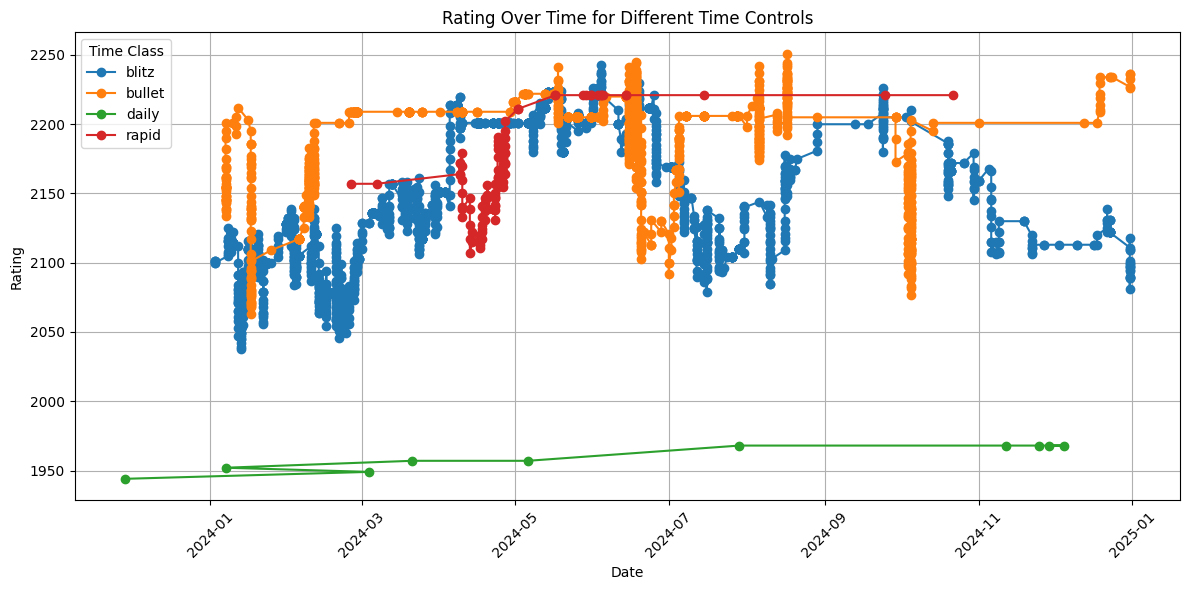

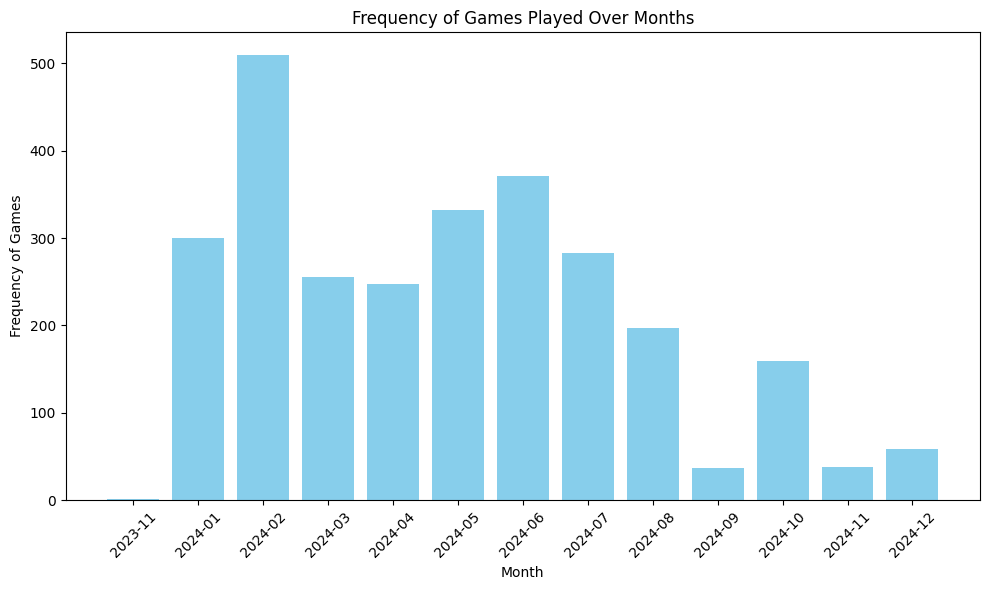

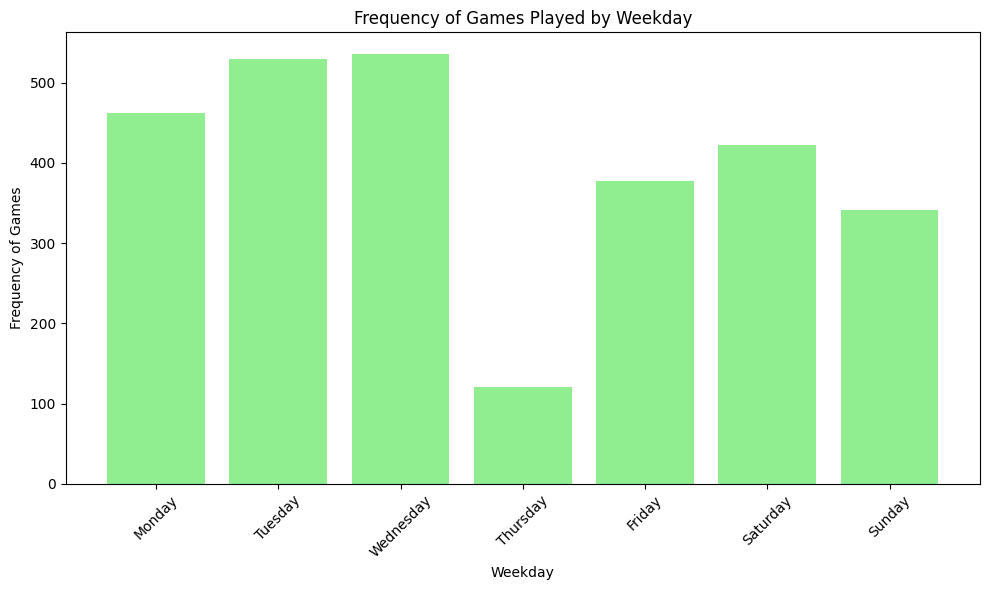

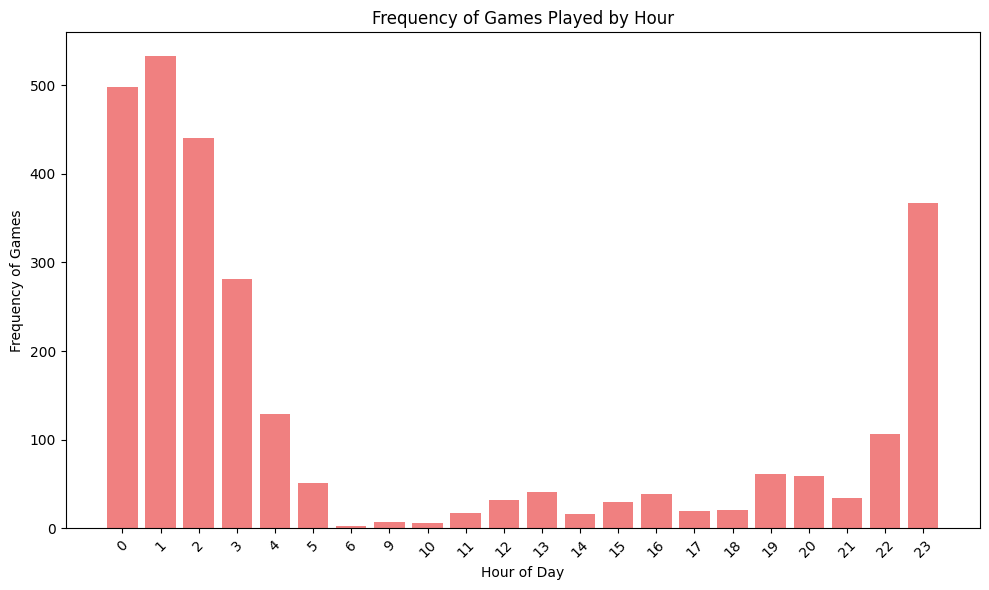

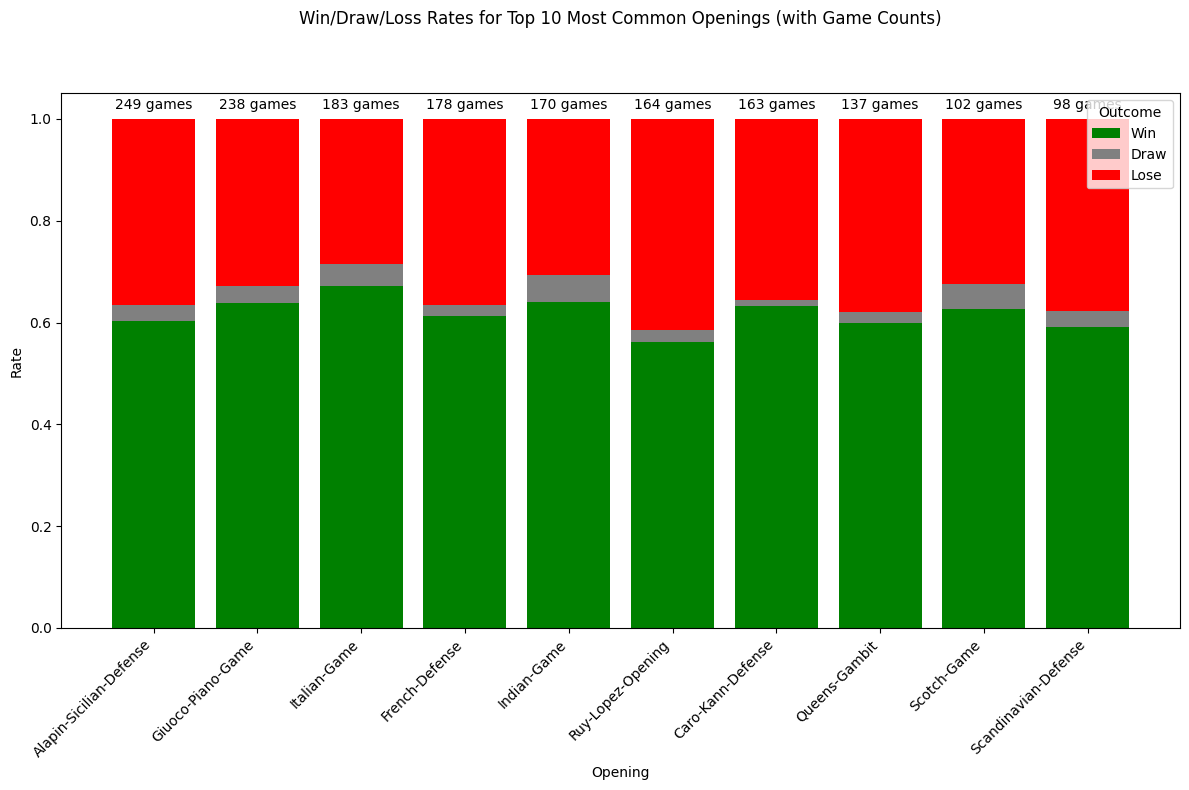

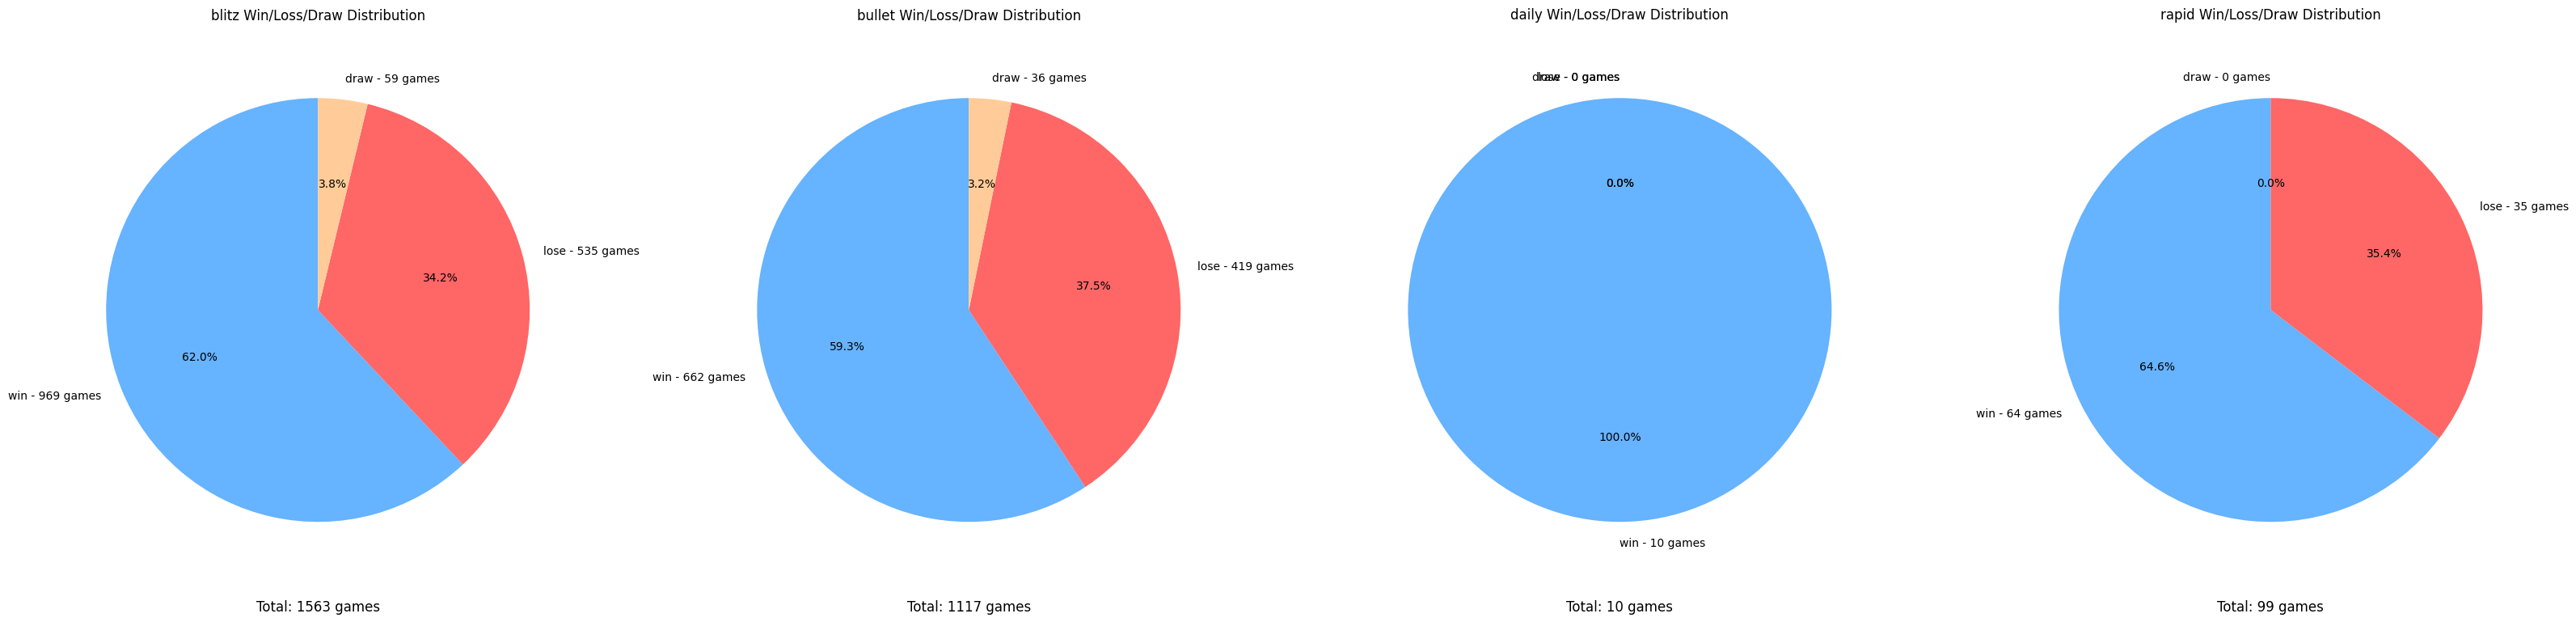

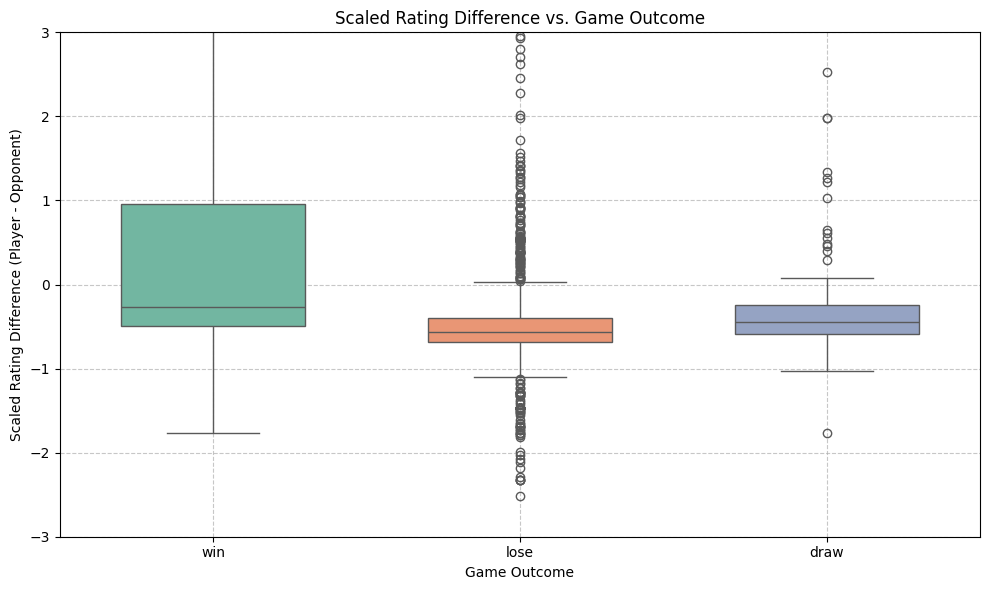

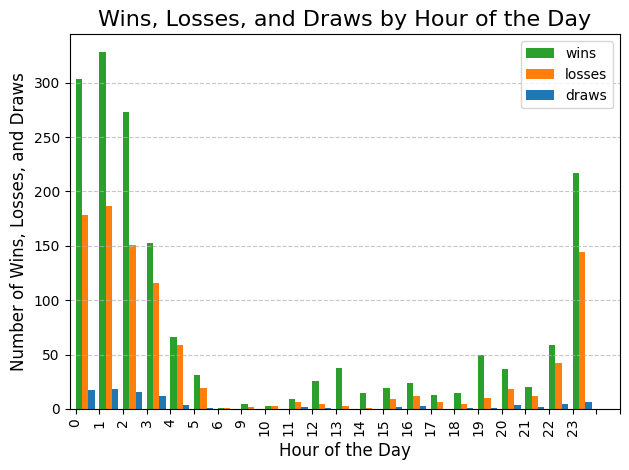

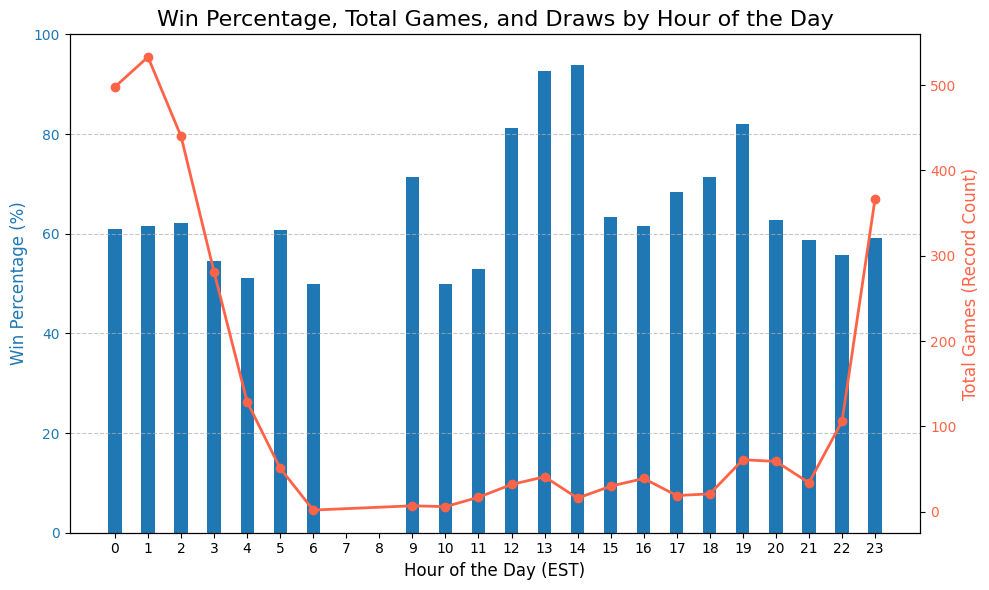

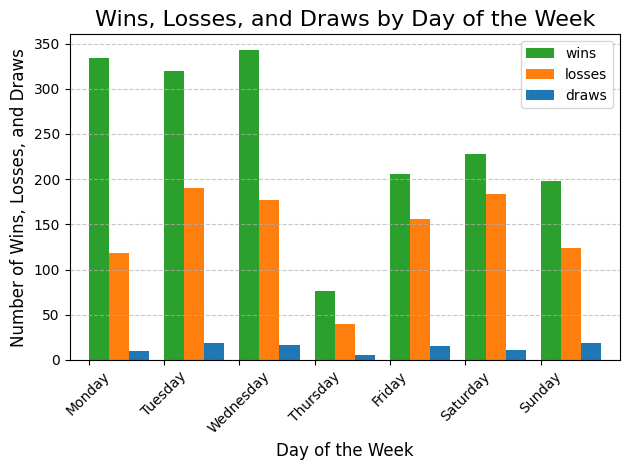

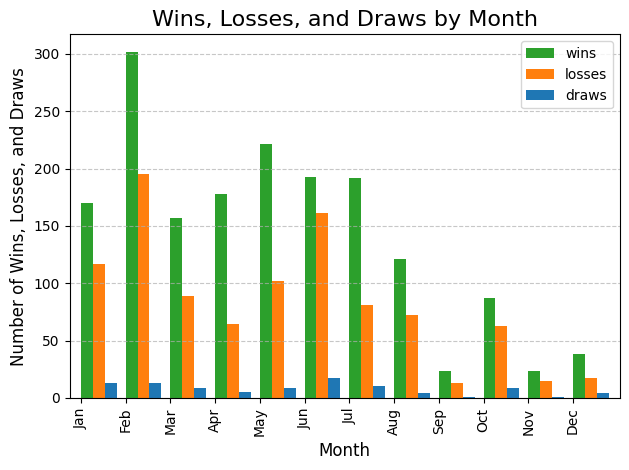

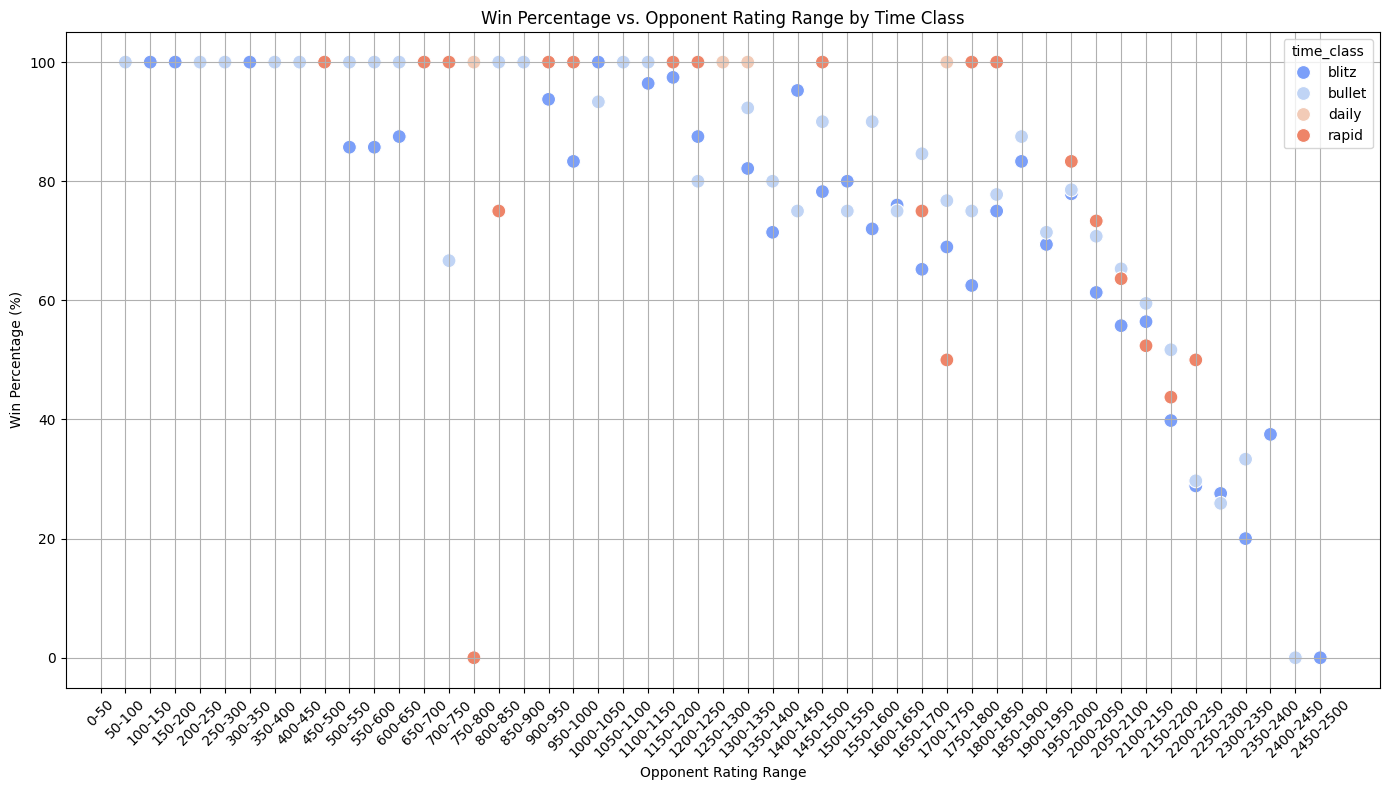

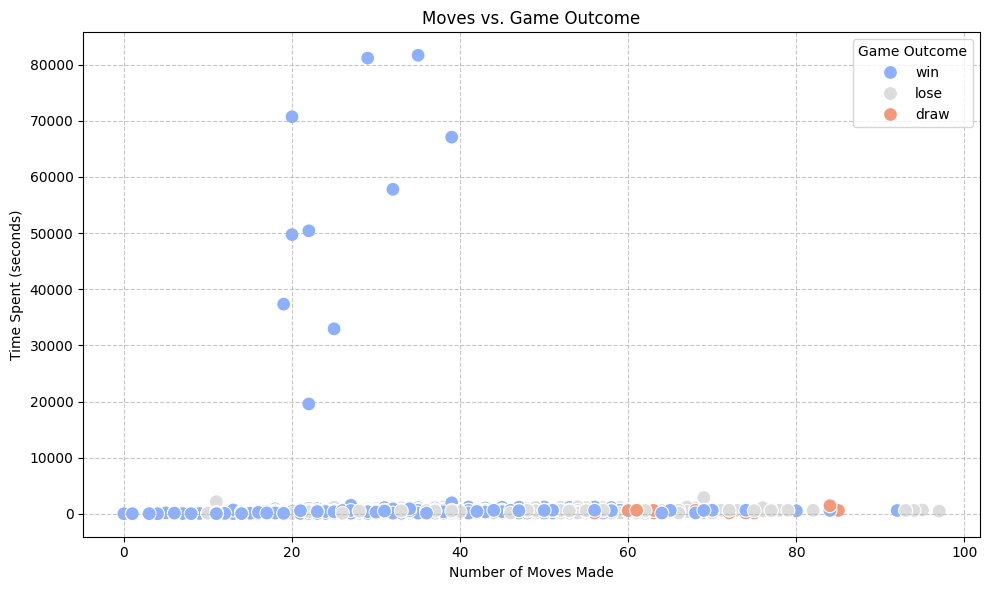

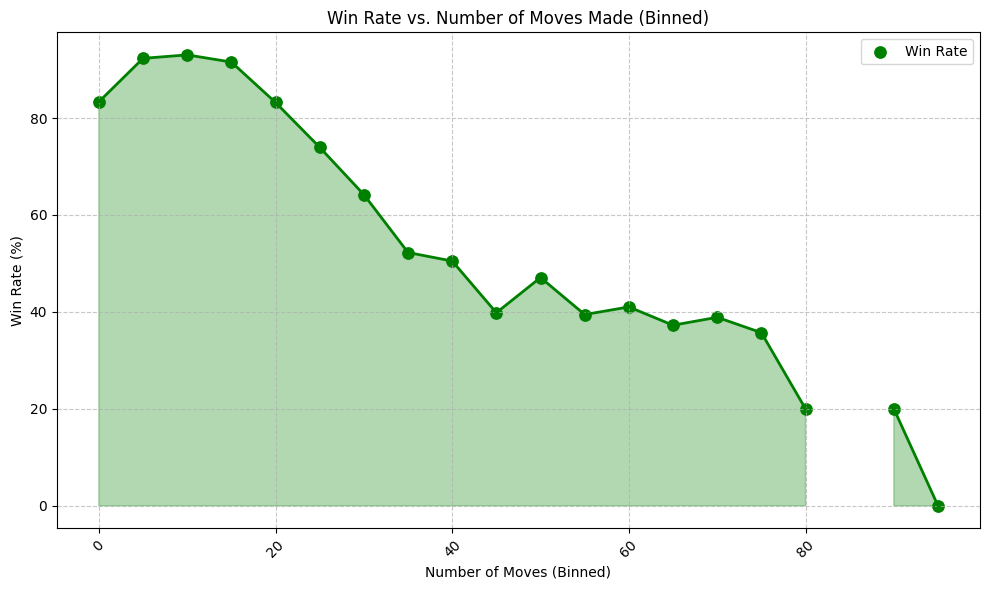

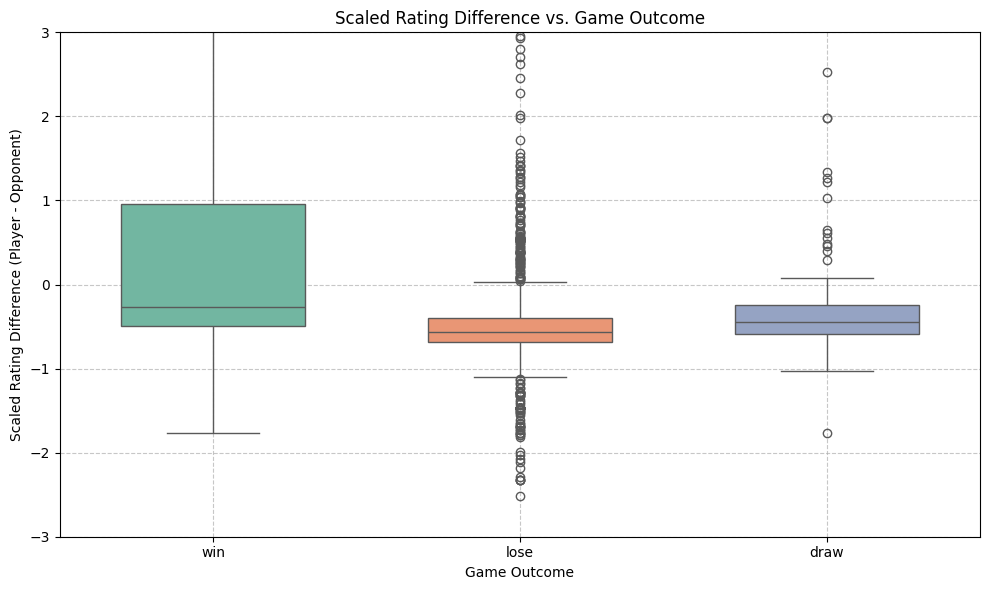

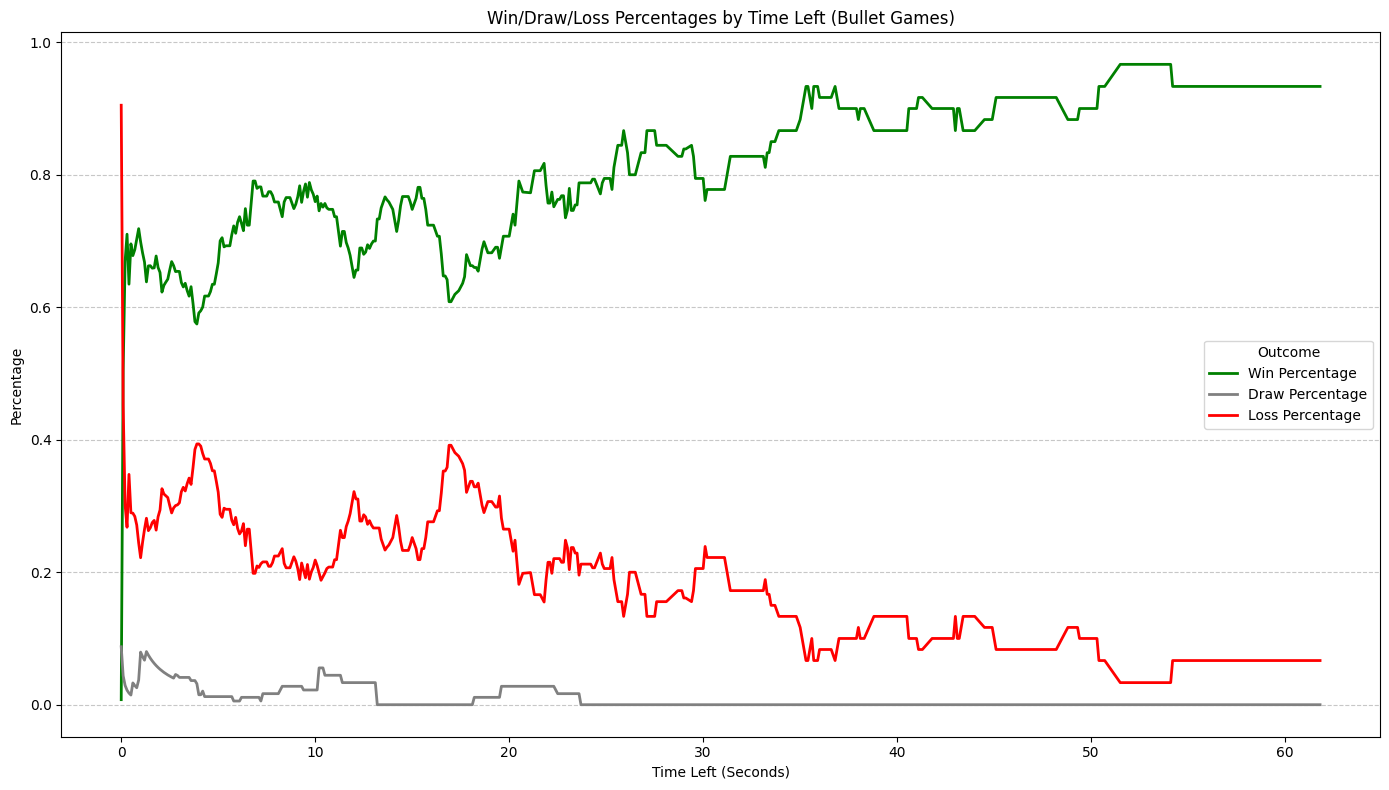

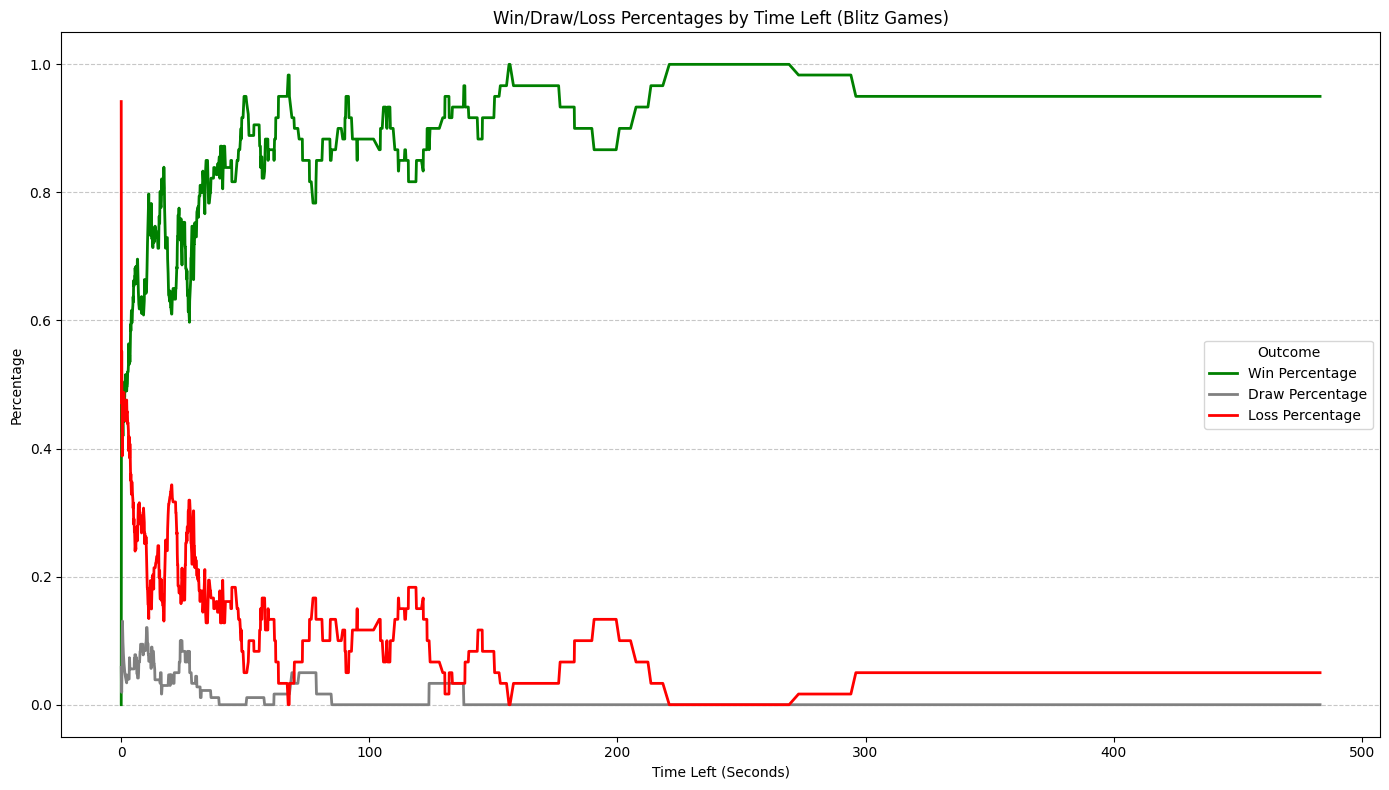

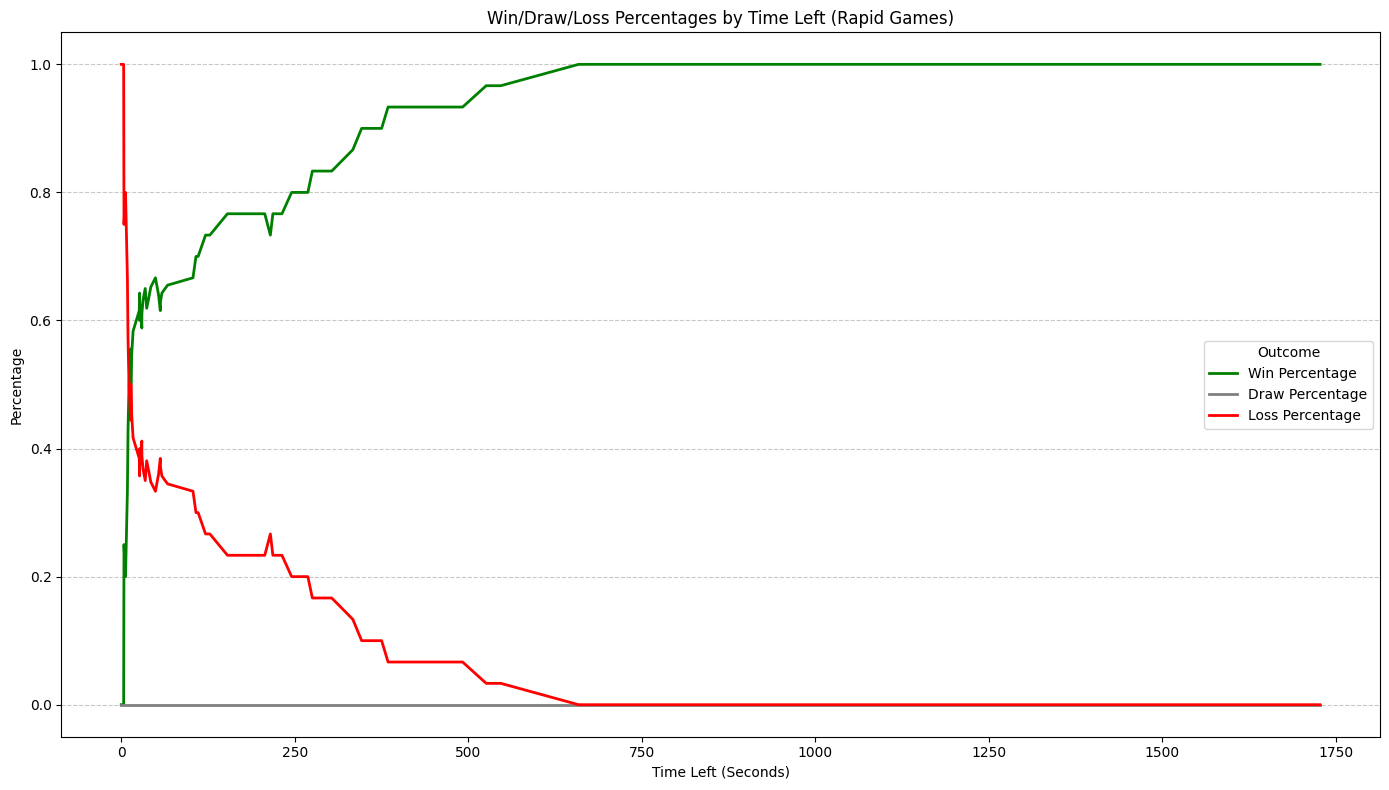

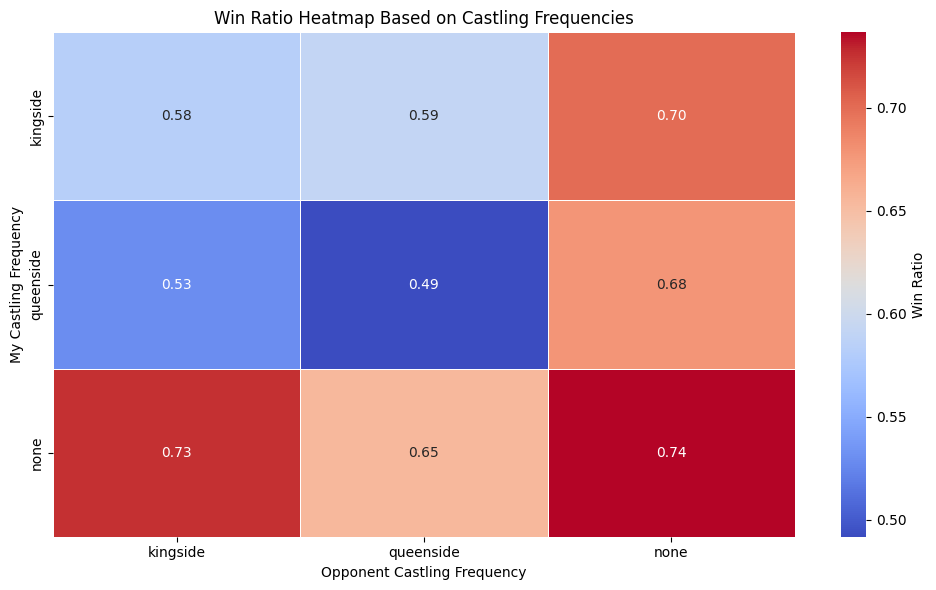

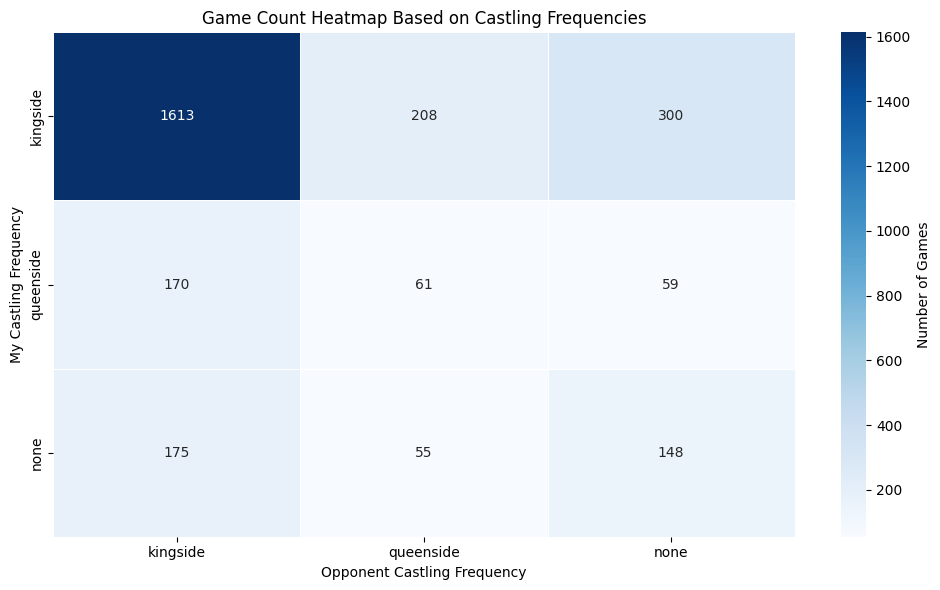

In [30]:

import time
import sys

pd.set_option('display.max_rows', None)  # No limit on rows


def drop_columns(df):
    if 'pgn' in df.columns:
        df = df.drop(columns=['pgn'])
        print(df.columns)
    return df


def main(username):
    global testing_df
    print("Chesslyzer booting...!!!")
    
    start_time = time.time()
    
    df = fetch_and_process_game_data(username)
    cleaned_df = clean_dataframe(df, username)
    cleaned_df = cleaned_df[cleaned_df['rules'] == 'chess']
    #print(cleaned_df['my_num_moves'].head())
    #print(cleaned_df['my_moves'].head())
    

    
    statistics = total_statistics(cleaned_df)
    
    more_statistics = collect_statistics(cleaned_df)
    print(more_statistics.keys())


    flag_statistics = get_flag_statistics(cleaned_df)

    
    for stat, value in statistics.items():
        print(f"{stat}: {value}")
    for stat, value in flag_statistics.items():
        print(f"{stat}: {value}")
    for stat, value in more_statistics.items():
        print(f"{stat}: {value}")


    final_df = drop_columns(cleaned_df)
    final_df.to_csv(f'csv/{username}.csv', index=False)

    plot_rating_progression_over_time(cleaned_df, output_dir)
    plot_game_statistics(final_df, output_dir)
    plot_opening_statistics(cleaned_df, output_dir)
    #plot_time_control_statistics(cleaned_df, output_dir)
    plot_time_class_statistics(cleaned_df, output_dir)
    plot_scaled_rating_difference_by_outcome(cleaned_df, output_dir)
    
    plot_game_outcome_by_hour(cleaned_df, output_dir)
    plot_game_outcome_by_day(cleaned_df, output_dir)
    plot_game_outcome_by_month(cleaned_df, output_dir)

    plot_win_percentage_vs_opp_rating(cleaned_df, output_dir)
    plot_moves_vs_game_outcome(cleaned_df, output_dir)
    plot_win_rate_vs_num_moves(cleaned_df, output_dir)
    plot_scaled_rating_difference_by_outcome(cleaned_df, output_dir)

    plot_game_outcome_by_time_left(cleaned_df, output_dir)
    plot_win_ratio_heatmap_by_castling(cleaned_df, output_dir)
    plot_game_count_heatmap_by_castling(cleaned_df, output_dir)

        
    testing_df = final_df.copy()
    
    end_time = time.time()
    duration = end_time - start_time
    print(f"Execution time: {duration:.2f} seconds")

# Boilerplate to run main when executed directly (for testing or debugging)
if __name__ == "__main__":
    '''if len(sys.argv) > 1:
        username = sys.argv[1]  # Get username from command line arguments
        main(username)
    else:
        print("Usage: python chesslytics.py <username>")'''
    username = "joebruin"
    main(username)



## Builds the PDF

In [31]:
import os
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Disable the limit


def combine_images_to_pdf(input_dir="static/images", output_file="combined_images.pdf"):
    # Get all PNG files in the specified directory
    png_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.png')], key=os.path.getctime)
    
    if not png_files:
        print(f"No PNG files found in the {input_dir} directory.")
        return
    
    # Open all the images
    images = [Image.open(f) for f in png_files]
    
    # Convert all images to RGB (necessary for saving as PDF)
    rgb_images = [img.convert('RGB') for img in images]
    
    # Save all images as a single PDF
    rgb_images[0].save(output_file, save_all=True, append_images=rgb_images[1:], resolution=100.0, quality=95)
    
    print(f"Combined PDF saved as {output_file}")

# Usage: Just call the function with the images directory and desired output file name
combine_images_to_pdf(input_dir='static/images', output_file=f'pdf/{username}_ChessLytics.pdf')


Combined PDF saved as pdf/joebruin_ChessLytics.pdf


In [32]:
### current problems, people with little games or no games, a lot of empty stuff such as eco 
### no value for either time_control or my_win_or_lose i think (or the time_control or my_win_or_lose fields are missing/NaN.)

#time left and game count

#goals to organize all the visualization functions and the extraction functions into another notebook